# MovieLens - Predicting a users's gender based on the movies they have watched

...

Summary:

- Prediction type: __Classification model__
- Domain: __Entertainment__
- Prediction target: __The gender of a user__ 
- Population size: __6039__

_Author: Dr. Patrick Urbanke_

# Background

...

It has been downloaded from the [CTU Prague relational learning repository](https://relational.fit.cvut.cz/dataset/MovieLens) (Motl and Schulte, 2015).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

from sklearn.feature_extraction.text import CountVectorizer

import getml

getml.engine.set_project('MovieLens')


Connected to project 'MovieLens'


Tuning is effective at improving our results, but it takes quite long, so we want to make it optional:

In [2]:
USE_FINE_TUNED = False

## 1. Loading data

### 1.1 Download from source

We begin by downloading the data from the source file:

In [3]:
conn = getml.database.connect_mariadb(
    host="relational.fit.cvut.cz",
    dbname="imdb_MovieLens",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(conn_id='default', dbname='imdb_MovieLens', dialect='mysql', 
           host='relational.fit.cvut.cz', port=3306)

In [4]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [5]:
users = load_if_needed("users")
u2base = load_if_needed("u2base")
movies = load_if_needed("movies")
movies2directors = load_if_needed("movies2directors")
directors = load_if_needed("directors")
movies2actors = load_if_needed("movies2actors")
actors = load_if_needed("actors")

### 1.2 Prepare data for getML

getML requires that we define *roles* for each of the columns.

In [6]:
users["target"] = (users.u_gender == 'F')

In [7]:
users.set_role("userid", getml.data.roles.join_key)
users.set_role("age", getml.data.roles.numerical)
users.set_role("occupation", getml.data.roles.categorical)
users.set_role("target", getml.data.roles.target)

users.save()

Name,userid,target,occupation,age,u_gender
Role,join_key,target,categorical,numerical,unused_string
0,1,1,2,1,F
1,51,1,2,1,F
2,75,1,2,1,F
3,86,1,2,1,F
4,99,1,2,1,F
,...,...,...,...,...
6034,5658,0,5,56,M
6035,5669,0,5,56,M
6036,5703,0,5,56,M


In [8]:
u2base.set_role(["userid", "movieid"], getml.data.roles.join_key)
u2base.set_role("rating", getml.data.roles.numerical)

u2base.save()

Name,userid,movieid,rating
Role,join_key,join_key,numerical
0,2,1964242,1
1,2,2219779,1
2,3,1856939,1
3,4,2273044,1
4,5,1681655,1
,...,...,...
996154,6040,2560616,5
996155,6040,2564194,5
996156,6040,2581228,5


In [9]:
movies.set_role("movieid", getml.data.roles.join_key)
movies.set_role(["year", "runningtime"], getml.data.roles.numerical)
movies.set_role(["isEnglish", "country"], getml.data.roles.categorical)

movies.save()

Name,movieid,isEnglish,country,year,runningtime
Role,join_key,categorical,categorical,numerical,numerical
0,1672052,T,other,3,2
1,1672111,T,other,4,2
2,1672580,T,USA,4,3
3,1672716,T,USA,4,2
4,1672946,T,USA,4,0
,...,...,...,...,...
3827,2591814,T,other,4,2
3828,2592334,T,USA,4,2
3829,2592963,F,France,2,2


In [10]:
movies2directors.set_role(["movieid", "directorid"], getml.data.roles.join_key)
movies2directors.set_role( "genre", getml.data.roles.categorical)

movies2directors.save()

Name,movieid,directorid,genre
Role,join_key,join_key,categorical
0,1672111,54934,Action
1,1672946,188940,Action
2,1679461,179783,Action
3,1691387,291700,Action
4,1693305,14663,Action
,...,...,...
4136,2570825,265215,Other
4137,2572478,149311,Other
4138,2577062,304827,Other


In [11]:
directors.set_role("directorid", getml.data.roles.join_key)
directors.set_role(["d_quality", "avg_revenue"], getml.data.roles.numerical)

directors.save()

Name,directorid,d_quality,avg_revenue
Role,join_key,numerical,numerical
0,67,4,1
1,92,2,3
2,284,4,0
3,708,4,1
4,746,4,4
,...,...,...
2196,305962,4,4
2197,305978,4,2
2198,306168,3,2


In [12]:
movies2actors.set_role(["movieid", "actorid"], getml.data.roles.join_key)
movies2actors.set_role( "cast_num", getml.data.roles.numerical)

movies2actors.save()

Name,movieid,actorid,cast_num
Role,join_key,join_key,numerical
0,1672580,981535,0
1,1672946,1094968,0
2,1673647,149985,0
3,1673647,261595,0
4,1673647,781357,0
,...,...,...
138344,2593313,947005,3
138345,2593313,1090590,3
138346,2593313,1347419,3


In [13]:
actors.set_role("actorid", getml.data.roles.join_key)
actors.set_role("a_quality", getml.data.roles.numerical)
actors.set_role("a_gender", getml.data.roles.categorical)

actors.save()

Name,actorid,a_gender,a_quality
Role,join_key,categorical,numerical
0,4,M,4
1,16,M,0
2,28,M,4
3,566,M,4
4,580,M,4
,...,...,...
98685,2749162,F,3
98686,2749168,F,3
98687,2749204,F,3


In [14]:
movies2actors_movies = movies2actors.join(
    "movies2actors_movies",
    other=actors,
    join_key="actorid"
)

movies2actors_movies = movies2actors_movies.group_by(
    name="movies2actors_movies",
    key="movieid",
    aggregations=[
        movies2actors_movies.cast_num.avg(alias="AVG_cast_num"),
        movies2actors_movies.a_quality.avg(alias="AVG_a_quality"),
        (movies2actors_movies.a_gender == 'F').as_num().avg(alias="share_female"),
        (movies2actors_movies.a_gender == 'F').as_num().sum(alias="num_female"),
        movies2actors_movies.a_gender.count(alias="COUNT_actors")
    ]
)

movies2actors_movies

Name,movieid,AVG_cast_num,AVG_a_quality,share_female,num_female,COUNT_actors
Role,join_key,unused_float,unused_float,unused_float,unused_float,unused_float
0,2593313,2.13793,3.86207,0.517241,15,29
1,2593112,2.4186,3.95349,0.232558,10,43
2,2592963,1.5,4,0.2,2,10
3,2592334,2.30556,3.19444,0.194444,7,36
4,2591814,1.70588,3.64706,0.235294,4,17
,...,...,...,...,...,...
3793,2561802,2.32432,3.86486,0.27027,10,37
3794,2562193,2.07407,3.44444,0.444444,12,27
3795,2562411,1.70588,3.41176,0.529412,9,17


In [15]:
movies2actors_movies.set_role(movies2actors_movies.unused_float_names, getml.data.roles.numerical)

movies2actors_movies.save()

Name,movieid,AVG_cast_num,AVG_a_quality,share_female,num_female,COUNT_actors
Role,join_key,numerical,numerical,numerical,numerical,numerical
0,2593313,2.13793,3.86207,0.517241,15,29
1,2593112,2.4186,3.95349,0.232558,10,43
2,2592963,1.5,4,0.2,2,10
3,2592334,2.30556,3.19444,0.194444,7,36
4,2591814,1.70588,3.64706,0.235294,4,17
,...,...,...,...,...,...
3793,2561802,2.32432,3.86486,0.27027,10,37
3794,2562193,2.07407,3.44444,0.444444,12,27
3795,2562411,1.70588,3.41176,0.529412,9,17


We need to separate our data set into a training, testing and validation set:

In [16]:
random = users.random()

is_training = (random < 0.75)
is_test = ~is_training

data_train = users.where("data_train", is_training)
data_test = users.where("data_test", is_test)

## 2. Predictive modelling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

### 2.1 Define relational model

To get started with relational learning, we need to specify the data model.

In [17]:
users_ph = getml.data.Placeholder('users')
u2base_ph = getml.data.Placeholder('u2base')
movies_ph = getml.data.Placeholder('movies')
movies2directors_ph = getml.data.Placeholder('movies2directors')
directors_ph = getml.data.Placeholder('directors')
movies2actors_movies_ph = getml.data.Placeholder('movies2actors_movies')

users_ph.join(
    u2base_ph,
    join_key='userid'
)

u2base_ph.join(
    movies_ph,
    join_key='movieid',
    relationship=getml.data.relationship.many_to_one
)

movies_ph.join(
    movies2directors_ph,
    join_key='movieid'
)

movies2directors_ph.join(
    directors_ph,
    join_key='directorid',
    relationship=getml.data.relationship.many_to_one
)

movies_ph.join(
    movies2actors_movies_ph,
    join_key='movieid',
    relationship=getml.data.relationship.many_to_one
)

users_ph

placeholder      other placeholder   allow lagged targets   horizon   join keys used   ...   
users              u2base                 False                  0.0       userid           ...   
u2base             movies                 False                  0.0       movieid          ...   
movies             movies2directors       False                  0.0       movieid          ...   
movies             movies2actors_movies   False                  0.0       movieid          ...   
movies2directors   directors              False                  0.0       directorid       ...   



other join keys used   other time stamps used   relationship   time stamps used   
userid                                          many-to-many                      
movieid                                         many-to-one                       
movieid                                         many-to-many                      
movieid                                         many-to-one                       
directorid                                      many-to-one                       



other join keys used   upper time stamps used   
userid                                          
movieid                                         
movieid                                         
movieid                                         
directorid

### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We can either use the relboost default parameters or some more fine-tuned parameters. Fine-tuning these parameters in this way can increase our predictive accuracy to 85%, but the training time increases to over 4 hours. We therefore assume that we want to use the default parameters.

In [18]:
relboost = getml.feature_learning.RelboostModel(
    num_features=30,
    num_subfeatures=10,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    seed=4367,
    num_threads=1
)

predictor = getml.predictors.XGBoostClassifier()

__Build the pipeline__

In [19]:
peripheral_ph = [
    u2base_ph, 
    movies_ph, 
    movies2directors_ph, 
    directors_ph, 
    movies2actors_movies_ph
]

pipe = getml.pipeline.Pipeline(
    tags=['relboost'],
    population=users_ph,
    peripheral=peripheral_ph,
    feature_learners=[relboost],
    predictors=[predictor]
)

### 2.3 Model training

In [20]:
peripheral = {
    "u2base": u2base, 
    "movies": movies, 
    "movies2directors": movies2directors,
    "directors": directors,
    "movies2actors_movies": movies2actors_movies
}

In [21]:
pipe.check(data_train, peripheral)

Checking data model...


INFO [JOIN KEYS NOT FOUND]: When joining the composite data frame 'u2base'-'movies'-'movies2actors_movies' that has been created by many-to-one joins or one-to-one joins and the composite data frame 'movies2directors'-'directors' that has been created by many-to-one joins or one-to-one joins over 'movieid' and 'movieid', there are no corresponding entries for 0.159513% of entries in 'movieid' in 'the composite data frame 'u2base'-'movies'-'movies2actors_movies' that has been created by many-to-one joins or one-to-one joins'. You might want to double-check your join keys.


In [22]:
pipe.fit(data_train, peripheral)

Checking data model...


INFO [JOIN KEYS NOT FOUND]: When joining the composite data frame 'u2base'-'movies'-'movies2actors_movies' that has been created by many-to-one joins or one-to-one joins and the composite data frame 'movies2directors'-'directors' that has been created by many-to-one joins or one-to-one joins over 'movieid' and 'movieid', there are no corresponding entries for 0.159513% of entries in 'movieid' in 'the composite data frame 'u2base'-'movies'-'movies2actors_movies' that has been created by many-to-one joins or one-to-one joins'. You might want to double-check your join keys.



Relboost: Training subfeatures...
[========================================] 100%

Relboost: Training subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 1h:39m:55.275279



Pipeline(preprocessors=[], feature_learners=['RelboostModel'], 
         feature_selectors=['XGBoostClassifier'], include_categorical=False, 
         peripheral=['u2base', 'movies', 'movies2directors', 'directors', 'movies2actors_movies'], 
         population='users', predictors=['XGBoostClassifier'], 
         tags=['multirel'], share_selected_features=0.5)

url: http://localhost:1709/#/getpipeline/MovieLens/w7Cznt/0/

### 2.4 Model evaluation

In [23]:
pipe.score(data_test, peripheral)


Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building features...
[========================================] 100%



,date time,set used,target,accuracy,auc,cross entropy
0,2021-01-05 16:35:04,data_train,target,0.82376,0.87474,0.38980
1,2021-01-05 16:35:06,data_test,target,0.80278,0.82192,0.44831


### 2.6 Studying features

__Feature correlations__

We want to analyze how the features are correlated with the target variable.

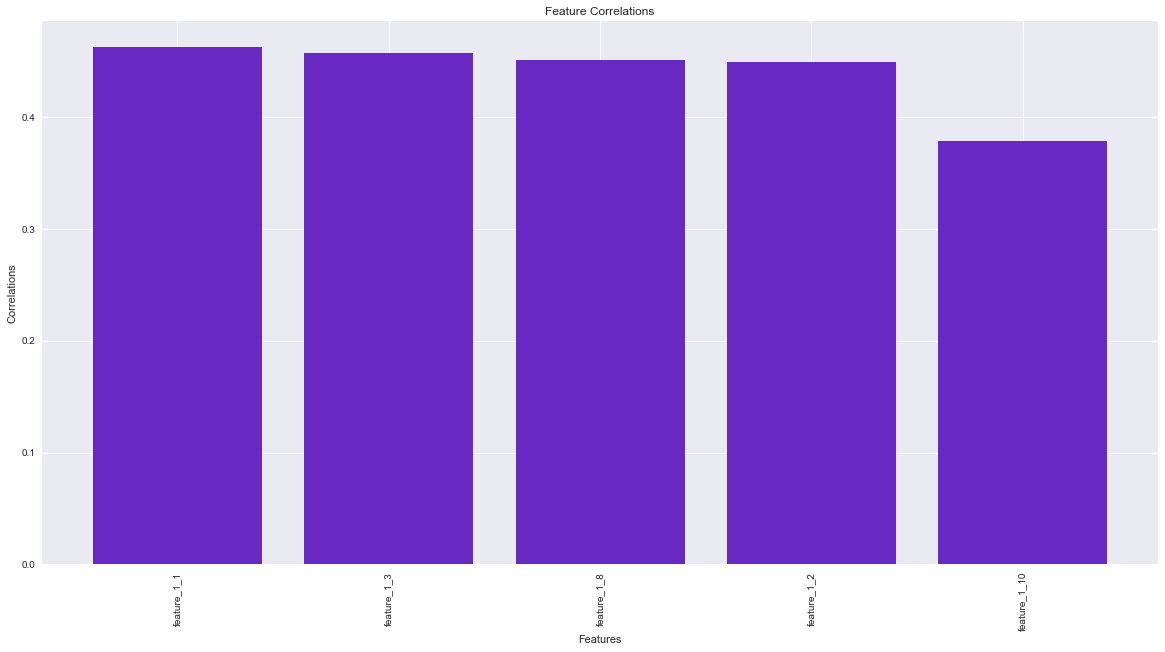

In [24]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title('Feature Correlations')
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

In [25]:
pipe.features.to_sql()

```sql
DROP TABLE IF EXISTS "FEATURE_1_1_1";

CREATE TABLE "FEATURE_1_1_1" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.382476 ) AND ( t2."genre" IN ( 'Adventure', 'Documentary', 'Horror' ) ) AND ( t1."rating" > 3.000000 ) THEN 4.439208215665474
        WHEN ( t5."share_female" > 0.382476 ) AND ( t2."genre" IN ( 'Adventure', 'Documentary', 'Horror' ) ) AND ( t1."rating" <= 3.000000 OR t1."rating" IS NULL ) THEN -5.269292315196469
        WHEN ( t5."share_female" > 0.382476 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Documentary', 'Horror' ) ) AND ( t1."rating" > 4.000000 ) THEN 13.30354246847786
        WHEN ( t5."share_female" > 0.382476 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Documentary', 'Horror' ) ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) THEN 8.274130535901007
        WHEN ( t5."share_female" <= 0.382476 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Adventure' ) ) AND ( t5."COUNT_actors" > 40.000000 ) THEN -1.857713357855236
        WHEN ( t5."share_female" <= 0.382476 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Adventure' ) ) AND ( t5."COUNT_actors" <= 40.000000 OR t5."COUNT_actors" IS NULL ) THEN 2.645775424268971
        WHEN ( t5."share_female" <= 0.382476 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) AND ( t5."share_female" > 0.045175 ) THEN -0.9497360770001571
        WHEN ( t5."share_female" <= 0.382476 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) AND ( t5."share_female" <= 0.045175 OR t5."share_female" IS NULL ) THEN -10.20547909859999
        ELSE NULL
    END
) AS "feature_1_1_1",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_2";

CREATE TABLE "FEATURE_1_1_2" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.301501 ) AND ( t2."genre" IN ( 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" > 2.771866 ) THEN -16.50419696299251
        WHEN ( t5."share_female" > 0.301501 ) AND ( t2."genre" IN ( 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" <= 2.771866 OR t5."AVG_cast_num" IS NULL ) THEN 3.815867737432649
        WHEN ( t5."share_female" > 0.301501 ) AND ( t2."genre" NOT IN ( 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" > 1.274344 ) THEN 7.8400515284803
        WHEN ( t5."share_female" > 0.301501 ) AND ( t2."genre" NOT IN ( 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" <= 1.274344 OR t5."AVG_cast_num" IS NULL ) THEN 32.26766122003202
        WHEN ( t5."share_female" <= 0.301501 OR t5."share_female" IS NULL ) AND ( t5."num_female" > 37.000000 ) AND ( t3."runningtime" > 2.000000 ) THEN -16.9364091309437
        WHEN ( t5."share_female" <= 0.301501 OR t5."share_female" IS NULL ) AND ( t5."num_female" > 37.000000 ) AND ( t3."runningtime" <= 2.000000 OR t3."runningtime" IS NULL ) THEN -60.30912578236073
        WHEN ( t5."share_female" <= 0.301501 OR t5."share_female" IS NULL ) AND ( t5."num_female" <= 37.000000 OR t5."num_female" IS NULL ) AND ( t2."genre" IN ( 'Horror', 'Other' ) ) THEN -7.99658217098335
        WHEN ( t5."share_female" <= 0.301501 OR t5."share_female" IS NULL ) AND ( t5."num_female" <= 37.000000 OR t5."num_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Horror', 'Other' ) ) THEN -1.488176065405836
        ELSE NULL
    END
) AS "feature_1_1_2",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_3";

CREATE TABLE "FEATURE_1_1_3" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.381868 ) AND ( t2."genre" IN ( 'Adventure', 'Animation', 'Crime', 'Documentary', 'Horror' ) ) AND ( t5."share_female" > 0.385803 ) THEN 0.6354602005267965
        WHEN ( t5."share_female" > 0.381868 ) AND ( t2."genre" IN ( 'Adventure', 'Animation', 'Crime', 'Documentary', 'Horror' ) ) AND ( t5."share_female" <= 0.385803 OR t5."share_female" IS NULL ) THEN 33.70057374890223
        WHEN ( t5."share_female" > 0.381868 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Animation', 'Crime', 'Documentary', 'Horror' ) ) AND ( t1."rating" > 4.000000 ) THEN 12.12443966760431
        WHEN ( t5."share_female" > 0.381868 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Animation', 'Crime', 'Documentary', 'Horror' ) ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) THEN 6.550796104845727
        WHEN ( t5."share_female" <= 0.381868 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Adventure' ) ) AND ( t5."COUNT_actors" > 59.000000 ) THEN -11.67865669949482
        WHEN ( t5."share_female" <= 0.381868 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Adventure' ) ) AND ( t5."COUNT_actors" <= 59.000000 OR t5."COUNT_actors" IS NULL ) THEN 2.043930893011091
        WHEN ( t5."share_female" <= 0.381868 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) AND ( t3."runningtime" > 1.000000 ) THEN -0.4966624164463792
        WHEN ( t5."share_female" <= 0.381868 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) AND ( t3."runningtime" <= 1.000000 OR t3."runningtime" IS NULL ) THEN -2.780528828810678
        ELSE NULL
    END
) AS "feature_1_1_3",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_4";

CREATE TABLE "FEATURE_1_1_4" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.368421 ) AND ( t2."genre" IN ( 'Adventure', 'Horror' ) ) AND ( t4."avg_revenue" > 1.000000 ) THEN -0.5864641826724319
        WHEN ( t5."share_female" > 0.368421 ) AND ( t2."genre" IN ( 'Adventure', 'Horror' ) ) AND ( t4."avg_revenue" <= 1.000000 OR t4."avg_revenue" IS NULL ) THEN 27.96327508257333
        WHEN ( t5."share_female" > 0.368421 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Horror' ) ) AND ( t1."rating" > 4.000000 ) THEN 8.958333827906717
        WHEN ( t5."share_female" > 0.368421 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Horror' ) ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) THEN 4.724085694671463
        WHEN ( t5."share_female" <= 0.368421 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" > 0.045334 ) THEN -1.192201724782698
        WHEN ( t5."share_female" <= 0.368421 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" <= 0.045334 OR t5."share_female" IS NULL ) THEN -11.93410059993483
        WHEN ( t5."share_female" <= 0.368421 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."COUNT_actors" > 53.000000 ) THEN -12.04898125190166
        WHEN ( t5."share_female" <= 0.368421 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."COUNT_actors" <= 53.000000 OR t5."COUNT_actors" IS NULL ) THEN 1.895000310854008
        ELSE NULL
    END
) AS "feature_1_1_4",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_5";

CREATE TABLE "FEATURE_1_1_5" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.340751 ) AND ( t5."AVG_cast_num" > 2.771217 ) AND ( t5."AVG_a_quality" > 3.061156 ) THEN -20.47408732234809
        WHEN ( t5."share_female" > 0.340751 ) AND ( t5."AVG_cast_num" > 2.771217 ) AND ( t5."AVG_a_quality" <= 3.061156 OR t5."AVG_a_quality" IS NULL ) THEN 31.46156360206684
        WHEN ( t5."share_female" > 0.340751 ) AND ( t5."AVG_cast_num" <= 2.771217 OR t5."AVG_cast_num" IS NULL ) AND ( t5."AVG_a_quality" > 3.013889 ) THEN 10.23008200855889
        WHEN ( t5."share_female" > 0.340751 ) AND ( t5."AVG_cast_num" <= 2.771217 OR t5."AVG_cast_num" IS NULL ) AND ( t5."AVG_a_quality" <= 3.013889 OR t5."AVG_a_quality" IS NULL ) THEN 2.111639194174437
        WHEN ( t5."share_female" <= 0.340751 OR t5."share_female" IS NULL ) AND ( t5."AVG_cast_num" > 2.618530 ) AND ( t2."genre" IN ( 'Adventure', 'Animation', 'Comedy', 'Other' ) ) THEN -8.962759670433982
        WHEN ( t5."share_female" <= 0.340751 OR t5."share_female" IS NULL ) AND ( t5."AVG_cast_num" > 2.618530 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Animation', 'Comedy', 'Other' ) ) THEN 1.495067929892586
        WHEN ( t5."share_female" <= 0.340751 OR t5."share_female" IS NULL ) AND ( t5."AVG_cast_num" <= 2.618530 OR t5."AVG_cast_num" IS NULL ) AND ( t5."num_female" > 18.000000 ) THEN 11.32868441289944
        WHEN ( t5."share_female" <= 0.340751 OR t5."share_female" IS NULL ) AND ( t5."AVG_cast_num" <= 2.618530 OR t5."AVG_cast_num" IS NULL ) AND ( t5."num_female" <= 18.000000 OR t5."num_female" IS NULL ) THEN 2.901307220236893
        ELSE NULL
    END
) AS "feature_1_1_5",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_6";

CREATE TABLE "FEATURE_1_1_6" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.380109 ) AND ( t5."AVG_cast_num" > 2.325457 ) AND ( t5."share_female" > 0.665532 ) THEN 69.21328508736823
        WHEN ( t5."share_female" > 0.380109 ) AND ( t5."AVG_cast_num" > 2.325457 ) AND ( t5."share_female" <= 0.665532 OR t5."share_female" IS NULL ) THEN 7.740623998221927
        WHEN ( t5."share_female" > 0.380109 ) AND ( t5."AVG_cast_num" <= 2.325457 OR t5."AVG_cast_num" IS NULL ) AND ( t5."COUNT_actors" > 34.000000 ) THEN -4.386012271327378
        WHEN ( t5."share_female" > 0.380109 ) AND ( t5."AVG_cast_num" <= 2.325457 OR t5."AVG_cast_num" IS NULL ) AND ( t5."COUNT_actors" <= 34.000000 OR t5."COUNT_actors" IS NULL ) THEN 4.513140641161097
        WHEN ( t5."share_female" <= 0.380109 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 3.958009 ) AND ( t3."country" IN ( 'other', 'UK' ) ) THEN -3.87434286870094
        WHEN ( t5."share_female" <= 0.380109 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 3.958009 ) AND ( t3."country" NOT IN ( 'other', 'UK' ) ) THEN 0.6444654482705473
        WHEN ( t5."share_female" <= 0.380109 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 3.958009 OR t5."AVG_a_quality" IS NULL ) AND ( t5."num_female" > 36.000000 ) THEN -9.418261535934395
        WHEN ( t5."share_female" <= 0.380109 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 3.958009 OR t5."AVG_a_quality" IS NULL ) AND ( t5."num_female" <= 36.000000 OR t5."num_female" IS NULL ) THEN -1.59437808696235
        ELSE NULL
    END
) AS "feature_1_1_6",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_7";

CREATE TABLE "FEATURE_1_1_7" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.414266 ) AND ( t5."AVG_cast_num" > 2.332696 ) AND ( t5."num_female" > 17.000000 ) THEN 8.134136408788001
        WHEN ( t5."share_female" > 0.414266 ) AND ( t5."AVG_cast_num" > 2.332696 ) AND ( t5."num_female" <= 17.000000 OR t5."num_female" IS NULL ) THEN 39.45804140432002
        WHEN ( t5."share_female" > 0.414266 ) AND ( t5."AVG_cast_num" <= 2.332696 OR t5."AVG_cast_num" IS NULL ) AND ( t5."AVG_a_quality" > 3.828125 ) THEN 8.387442618410814
        WHEN ( t5."share_female" > 0.414266 ) AND ( t5."AVG_cast_num" <= 2.332696 OR t5."AVG_cast_num" IS NULL ) AND ( t5."AVG_a_quality" <= 3.828125 OR t5."AVG_a_quality" IS NULL ) THEN -0.1795073850892733
        WHEN ( t5."share_female" <= 0.414266 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.179290 ) AND ( t2."genre" IN ( 'Action', 'Comedy', 'Drama', 'Horror' ) ) THEN 1.231178287924454
        WHEN ( t5."share_female" <= 0.414266 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.179290 ) AND ( t2."genre" NOT IN ( 'Action', 'Comedy', 'Drama', 'Horror' ) ) THEN 3.676569927461943
        WHEN ( t5."share_female" <= 0.414266 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.179290 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.127239 ) THEN -4.170527749879795
        WHEN ( t5."share_female" <= 0.414266 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.179290 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.127239 OR t5."share_female" IS NULL ) THEN 0.1269839317447451
        ELSE NULL
    END
) AS "feature_1_1_7",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_8";

CREATE TABLE "FEATURE_1_1_8" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.382114 ) AND ( t5."share_female" > 0.492898 ) AND ( t5."num_female" > 24.000000 ) THEN 13.10519189664096
        WHEN ( t5."share_female" > 0.382114 ) AND ( t5."share_female" > 0.492898 ) AND ( t5."num_female" <= 24.000000 OR t5."num_female" IS NULL ) THEN 3.153297057726014
        WHEN ( t5."share_female" > 0.382114 ) AND ( t5."share_female" <= 0.492898 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.483571 ) THEN -17.77160031376027
        WHEN ( t5."share_female" > 0.382114 ) AND ( t5."share_female" <= 0.492898 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.483571 OR t5."share_female" IS NULL ) THEN 0.5713811187419812
        WHEN ( t5."share_female" <= 0.382114 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" > 0.049636 ) THEN -4.19667011766865
        WHEN ( t5."share_female" <= 0.382114 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" <= 0.049636 OR t5."share_female" IS NULL ) THEN -14.7233761567303
        WHEN ( t5."share_female" <= 0.382114 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" > 2.072368 ) THEN -4.873530949204038
        WHEN ( t5."share_female" <= 0.382114 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" <= 2.072368 OR t5."AVG_cast_num" IS NULL ) THEN 2.086716352701849
        ELSE NULL
    END
) AS "feature_1_1_8",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_9";

CREATE TABLE "FEATURE_1_1_9" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.297260 ) AND ( t5."AVG_a_quality" > 3.034021 ) AND ( t5."share_female" > 0.599745 ) THEN -5.791550206557184
        WHEN ( t5."share_female" > 0.297260 ) AND ( t5."AVG_a_quality" > 3.034021 ) AND ( t5."share_female" <= 0.599745 OR t5."share_female" IS NULL ) THEN 3.650118025757397
        WHEN ( t5."share_female" > 0.297260 ) AND ( t5."AVG_a_quality" <= 3.034021 OR t5."AVG_a_quality" IS NULL ) AND ( t3."runningtime" > 2.000000 ) THEN 17.68028359326993
        WHEN ( t5."share_female" > 0.297260 ) AND ( t5."AVG_a_quality" <= 3.034021 OR t5."AVG_a_quality" IS NULL ) AND ( t3."runningtime" <= 2.000000 OR t3."runningtime" IS NULL ) THEN -4.311860566695382
        WHEN ( t5."share_female" <= 0.297260 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 136.000000 ) AND ( t1."rating" > 3.000000 ) THEN -22.69083569017657
        WHEN ( t5."share_female" <= 0.297260 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 136.000000 ) AND ( t1."rating" <= 3.000000 OR t1."rating" IS NULL ) THEN -5.046022278946797
        WHEN ( t5."share_female" <= 0.297260 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 136.000000 OR t5."COUNT_actors" IS NULL ) AND ( t5."AVG_cast_num" > 2.808252 ) THEN 112.1672726894042
        WHEN ( t5."share_female" <= 0.297260 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 136.000000 OR t5."COUNT_actors" IS NULL ) AND ( t5."AVG_cast_num" <= 2.808252 OR t5."AVG_cast_num" IS NULL ) THEN -1.209298704013169
        ELSE NULL
    END
) AS "feature_1_1_9",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_10";

CREATE TABLE "FEATURE_1_1_10" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.302198 ) AND ( t2."genre" IN ( 'Drama' ) ) AND ( t5."COUNT_actors" > 81.000000 ) THEN -28.06176352550474
        WHEN ( t5."share_female" > 0.302198 ) AND ( t2."genre" IN ( 'Drama' ) ) AND ( t5."COUNT_actors" <= 81.000000 OR t5."COUNT_actors" IS NULL ) THEN -2.007557195237608
        WHEN ( t5."share_female" > 0.302198 ) AND ( t2."genre" NOT IN ( 'Drama' ) ) AND ( t5."AVG_cast_num" > 2.764702 ) THEN -23.76853312507381
        WHEN ( t5."share_female" > 0.302198 ) AND ( t2."genre" NOT IN ( 'Drama' ) ) AND ( t5."AVG_cast_num" <= 2.764702 OR t5."AVG_cast_num" IS NULL ) THEN -7.453420525872659
        WHEN ( t5."share_female" <= 0.302198 OR t5."share_female" IS NULL ) AND ( t4."avg_revenue" > 3.000000 ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN -10.59807398706811
        WHEN ( t5."share_female" <= 0.302198 OR t5."share_female" IS NULL ) AND ( t4."avg_revenue" > 3.000000 ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN -6.123043764730713
        WHEN ( t5."share_female" <= 0.302198 OR t5."share_female" IS NULL ) AND ( t4."avg_revenue" <= 3.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."AVG_cast_num" > 2.319031 ) THEN -18.01050519829709
        WHEN ( t5."share_female" <= 0.302198 OR t5."share_female" IS NULL ) AND ( t4."avg_revenue" <= 3.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."AVG_cast_num" <= 2.319031 OR t5."AVG_cast_num" IS NULL ) THEN -11.2804096838691
        ELSE NULL
    END
) AS "feature_1_1_10",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_11";

CREATE TABLE "FEATURE_1_1_11" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.382920 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" > 2.332063 ) THEN 0.06145210103152271
        WHEN ( t5."share_female" > 0.382920 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" <= 2.332063 OR t5."AVG_cast_num" IS NULL ) THEN 0.00601240299661283
        WHEN ( t5."share_female" > 0.382920 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t5."share_female" > 0.396011 ) THEN 0.07192580435995818
        WHEN ( t5."share_female" > 0.382920 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t5."share_female" <= 0.396011 OR t5."share_female" IS NULL ) THEN 0.1951058656462275
        WHEN ( t5."share_female" <= 0.382920 OR t5."share_female" IS NULL ) AND ( t5."num_female" > 29.000000 ) AND ( t2."genre" IN ( 'Action', 'Comedy', 'Documentary', 'Other' ) ) THEN -0.09732031516054282
        WHEN ( t5."share_female" <= 0.382920 OR t5."share_female" IS NULL ) AND ( t5."num_female" > 29.000000 ) AND ( t2."genre" NOT IN ( 'Action', 'Comedy', 'Documentary', 'Other' ) ) THEN 0.0538328307201344
        WHEN ( t5."share_female" <= 0.382920 OR t5."share_female" IS NULL ) AND ( t5."num_female" <= 29.000000 OR t5."num_female" IS NULL ) AND ( t5."share_female" > 0.029271 ) THEN -0.008752558146737978
        WHEN ( t5."share_female" <= 0.382920 OR t5."share_female" IS NULL ) AND ( t5."num_female" <= 29.000000 OR t5."num_female" IS NULL ) AND ( t5."share_female" <= 0.029271 OR t5."share_female" IS NULL ) THEN -0.1001427062643074
        ELSE NULL
    END
) AS "feature_1_1_11",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_12";

CREATE TABLE "FEATURE_1_1_12" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.381085 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" > 2.328903 ) THEN 0.05832759357902421
        WHEN ( t5."share_female" > 0.381085 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" <= 2.328903 OR t5."AVG_cast_num" IS NULL ) THEN 0.003617067425763789
        WHEN ( t5."share_female" > 0.381085 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t5."AVG_cast_num" > 2.034340 ) THEN 0.1887181347791278
        WHEN ( t5."share_female" > 0.381085 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t5."AVG_cast_num" <= 2.034340 OR t5."AVG_cast_num" IS NULL ) THEN 0.06457916075592603
        WHEN ( t5."share_female" <= 0.381085 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 95.000000 ) AND ( t5."num_female" > 14.000000 ) THEN -0.06334633905376542
        WHEN ( t5."share_female" <= 0.381085 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 95.000000 ) AND ( t5."num_female" <= 14.000000 OR t5."num_female" IS NULL ) THEN -0.3072234915609658
        WHEN ( t5."share_female" <= 0.381085 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 95.000000 OR t5."COUNT_actors" IS NULL ) AND ( t5."AVG_a_quality" > 4.311688 ) THEN -0.1176895191588121
        WHEN ( t5."share_female" <= 0.381085 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 95.000000 OR t5."COUNT_actors" IS NULL ) AND ( t5."AVG_a_quality" <= 4.311688 OR t5."AVG_a_quality" IS NULL ) THEN -0.008451925200749751
        ELSE NULL
    END
) AS "feature_1_1_12",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_13";

CREATE TABLE "FEATURE_1_1_13" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.381018 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t3."year" > 2.000000 ) THEN 0.03313686213847201
        WHEN ( t5."share_female" > 0.381018 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) THEN 0.2557694188095031
        WHEN ( t5."share_female" > 0.381018 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."share_female" > 0.395667 ) THEN 0.0116771847956914
        WHEN ( t5."share_female" > 0.381018 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."share_female" <= 0.395667 OR t5."share_female" IS NULL ) THEN -0.2753002228976409
        WHEN ( t5."share_female" <= 0.381018 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 4.286834 ) AND ( t5."AVG_a_quality" > 4.429777 ) THEN 0.04079465031972577
        WHEN ( t5."share_female" <= 0.381018 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 4.286834 ) AND ( t5."AVG_a_quality" <= 4.429777 OR t5."AVG_a_quality" IS NULL ) THEN -0.2399318173511911
        WHEN ( t5."share_female" <= 0.381018 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 4.286834 OR t5."AVG_a_quality" IS NULL ) AND ( t5."AVG_cast_num" > 2.838545 ) THEN -0.2913460020879832
        WHEN ( t5."share_female" <= 0.381018 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 4.286834 OR t5."AVG_a_quality" IS NULL ) AND ( t5."AVG_cast_num" <= 2.838545 OR t5."AVG_cast_num" IS NULL ) THEN -0.009112445061638726
        ELSE NULL
    END
) AS "feature_1_1_13",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_14";

CREATE TABLE "FEATURE_1_1_14" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.382271 ) AND ( t4."avg_revenue" > 3.000000 ) AND ( t5."AVG_a_quality" > 3.788280 ) THEN 0.1181847878975137
        WHEN ( t5."share_female" > 0.382271 ) AND ( t4."avg_revenue" > 3.000000 ) AND ( t5."AVG_a_quality" <= 3.788280 OR t5."AVG_a_quality" IS NULL ) THEN 0.03393118127709603
        WHEN ( t5."share_female" > 0.382271 ) AND ( t4."avg_revenue" <= 3.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."COUNT_actors" > 130.000000 ) THEN -0.4824460454399158
        WHEN ( t5."share_female" > 0.382271 ) AND ( t4."avg_revenue" <= 3.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."COUNT_actors" <= 130.000000 OR t5."COUNT_actors" IS NULL ) THEN 0.02006535910554342
        WHEN ( t5."share_female" <= 0.382271 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 4.086614 ) AND ( t5."AVG_a_quality" > 4.144781 ) THEN -0.03312801800937196
        WHEN ( t5."share_female" <= 0.382271 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 4.086614 ) AND ( t5."AVG_a_quality" <= 4.144781 OR t5."AVG_a_quality" IS NULL ) THEN -0.4071414963722156
        WHEN ( t5."share_female" <= 0.382271 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 4.086614 OR t5."AVG_a_quality" IS NULL ) AND ( t2."genre" IN ( 'Adventure' ) ) THEN 0.007866457577259536
        WHEN ( t5."share_female" <= 0.382271 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 4.086614 OR t5."AVG_a_quality" IS NULL ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) THEN -0.01268484121779736
        ELSE NULL
    END
) AS "feature_1_1_14",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_15";

CREATE TABLE "FEATURE_1_1_15" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.355586 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t2."genre" IN ( 'Action', 'Adventure', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) THEN 0.01525818524944128
        WHEN ( t5."share_female" > 0.355586 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t2."genre" NOT IN ( 'Action', 'Adventure', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) THEN 0.05472174272163986
        WHEN ( t5."share_female" > 0.355586 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t4."avg_revenue" > 0.000000 ) THEN -0.01506108776410837
        WHEN ( t5."share_female" > 0.355586 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t4."avg_revenue" <= 0.000000 OR t4."avg_revenue" IS NULL ) THEN 0.07589465424941813
        WHEN ( t5."share_female" <= 0.355586 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.354409 ) AND ( t1."rating" > 3.000000 ) THEN -0.3189183615658661
        WHEN ( t5."share_female" <= 0.355586 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.354409 ) AND ( t1."rating" <= 3.000000 OR t1."rating" IS NULL ) THEN -0.1205352228159956
        WHEN ( t5."share_female" <= 0.355586 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.354409 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.349589 ) THEN 0.08368627376048722
        WHEN ( t5."share_female" <= 0.355586 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.354409 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.349589 OR t5."share_female" IS NULL ) THEN -0.01178059016824378
        ELSE NULL
    END
) AS "feature_1_1_15",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_16";

CREATE TABLE "FEATURE_1_1_16" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.381471 ) AND ( t5."COUNT_actors" > 83.000000 ) AND ( t3."runningtime" > 2.000000 ) THEN -0.0250258392328856
        WHEN ( t5."share_female" > 0.381471 ) AND ( t5."COUNT_actors" > 83.000000 ) AND ( t3."runningtime" <= 2.000000 OR t3."runningtime" IS NULL ) THEN -0.2433274222065845
        WHEN ( t5."share_female" > 0.381471 ) AND ( t5."COUNT_actors" <= 83.000000 OR t5."COUNT_actors" IS NULL ) AND ( t4."avg_revenue" > 2.000000 ) THEN 0.04519987316787903
        WHEN ( t5."share_female" > 0.381471 ) AND ( t5."COUNT_actors" <= 83.000000 OR t5."COUNT_actors" IS NULL ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) THEN 0.006122577283825829
        WHEN ( t5."share_female" <= 0.381471 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Other' ) ) AND ( t5."COUNT_actors" > 176.000000 ) THEN -0.2396103355996192
        WHEN ( t5."share_female" <= 0.381471 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Other' ) ) AND ( t5."COUNT_actors" <= 176.000000 OR t5."COUNT_actors" IS NULL ) THEN -0.01298439182961336
        WHEN ( t5."share_female" <= 0.381471 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" > 0.378762 ) THEN 0.6649644497810465
        WHEN ( t5."share_female" <= 0.381471 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" <= 0.378762 OR t5."share_female" IS NULL ) THEN 0.00143167112708014
        ELSE NULL
    END
) AS "feature_1_1_16",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_17";

CREATE TABLE "FEATURE_1_1_17" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.383333 ) AND ( t5."share_female" > 0.386919 ) AND ( t3."year" > 2.000000 ) THEN 0.02177885892119465
        WHEN ( t5."share_female" > 0.383333 ) AND ( t5."share_female" > 0.386919 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) THEN 0.07686810786778889
        WHEN ( t5."share_female" > 0.383333 ) AND ( t5."share_female" <= 0.386919 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Comedy', 'Documentary', 'Drama', 'Horror' ) ) THEN 0.1239307122960044
        WHEN ( t5."share_female" > 0.383333 ) AND ( t5."share_female" <= 0.386919 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Comedy', 'Documentary', 'Drama', 'Horror' ) ) THEN 0.3321641438165037
        WHEN ( t5."share_female" <= 0.383333 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.030251 ) AND ( t5."COUNT_actors" > 220.000000 ) THEN -0.2210862074145951
        WHEN ( t5."share_female" <= 0.383333 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.030251 ) AND ( t5."COUNT_actors" <= 220.000000 OR t5."COUNT_actors" IS NULL ) THEN -0.00932452560030704
        WHEN ( t5."share_female" <= 0.383333 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.030251 OR t5."share_female" IS NULL ) AND ( t3."country" IN ( 'France' ) ) THEN 1.574168402044292
        WHEN ( t5."share_female" <= 0.383333 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.030251 OR t5."share_female" IS NULL ) AND ( t3."country" NOT IN ( 'France' ) ) THEN -0.09842692505617083
        ELSE NULL
    END
) AS "feature_1_1_17",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_18";

CREATE TABLE "FEATURE_1_1_18" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.382393 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t5."AVG_a_quality" > 3.902209 ) THEN 0.1083932903796876
        WHEN ( t5."share_female" > 0.382393 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t5."AVG_a_quality" <= 3.902209 OR t5."AVG_a_quality" IS NULL ) THEN 0.02323104800069518
        WHEN ( t5."share_female" > 0.382393 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."share_female" > 0.404027 ) THEN 0.0163941099810157
        WHEN ( t5."share_female" > 0.382393 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."share_female" <= 0.404027 OR t5."share_female" IS NULL ) THEN -0.1356106870785422
        WHEN ( t5."share_female" <= 0.382393 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.079582 ) AND ( t5."num_female" > 43.000000 ) THEN -0.2033862858659178
        WHEN ( t5."share_female" <= 0.382393 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.079582 ) AND ( t5."num_female" <= 43.000000 OR t5."num_female" IS NULL ) THEN -0.00668626862338815
        WHEN ( t5."share_female" <= 0.382393 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.079582 OR t5."share_female" IS NULL ) AND ( t1."rating" > 3.000000 ) THEN -0.05807182069999459
        WHEN ( t5."share_female" <= 0.382393 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.079582 OR t5."share_female" IS NULL ) AND ( t1."rating" <= 3.000000 OR t1."rating" IS NULL ) THEN -0.01894113773931498
        ELSE NULL
    END
) AS "feature_1_1_18",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_19";

CREATE TABLE "FEATURE_1_1_19" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.357823 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" > 2.336694 ) THEN 0.04022290662837702
        WHEN ( t5."share_female" > 0.357823 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" <= 2.336694 OR t5."AVG_cast_num" IS NULL ) THEN -0.001658661670963714
        WHEN ( t5."share_female" > 0.357823 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t1."rating" > 4.000000 ) THEN 0.08558016688296999
        WHEN ( t5."share_female" > 0.357823 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) THEN 0.0394402537332476
        WHEN ( t5."share_female" <= 0.357823 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 136.000000 ) AND ( t1."rating" > 1.000000 ) THEN -0.1400611919743407
        WHEN ( t5."share_female" <= 0.357823 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 136.000000 ) AND ( t1."rating" <= 1.000000 OR t1."rating" IS NULL ) THEN 0.09727846371553717
        WHEN ( t5."share_female" <= 0.357823 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 136.000000 OR t5."COUNT_actors" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN -0.01301188169927387
        WHEN ( t5."share_female" <= 0.357823 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 136.000000 OR t5."COUNT_actors" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN 0.005838648178728916
        ELSE NULL
    END
) AS "feature_1_1_19",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_20";

CREATE TABLE "FEATURE_1_1_20" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.357241 ) AND ( t1."rating" > 4.000000 ) AND ( t5."share_female" > 0.446226 ) THEN -0.01285209064843055
        WHEN ( t5."share_female" > 0.357241 ) AND ( t1."rating" > 4.000000 ) AND ( t5."share_female" <= 0.446226 OR t5."share_female" IS NULL ) THEN 0.07264997485148414
        WHEN ( t5."share_female" > 0.357241 ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) AND ( t5."AVG_cast_num" > 2.766866 ) THEN -0.2025481342171267
        WHEN ( t5."share_female" > 0.357241 ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) AND ( t5."AVG_cast_num" <= 2.766866 OR t5."AVG_cast_num" IS NULL ) THEN 0.01959289144372038
        WHEN ( t5."share_female" <= 0.357241 OR t5."share_female" IS NULL ) AND ( t1."rating" > 4.000000 ) AND ( t2."genre" IN ( 'Adventure' ) ) THEN 0.02226831508827206
        WHEN ( t5."share_female" <= 0.357241 OR t5."share_female" IS NULL ) AND ( t1."rating" > 4.000000 ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) THEN -0.02175196935098901
        WHEN ( t5."share_female" <= 0.357241 OR t5."share_female" IS NULL ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Adventure', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN -0.010338853912309
        WHEN ( t5."share_female" <= 0.357241 OR t5."share_female" IS NULL ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Adventure', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN 0.005369698571236299
        ELSE NULL
    END
) AS "feature_1_1_20",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1";

CREATE TABLE "FEATURE_1_1" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 2.460768 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 33.589247 ) AND ( t1."age" > 48.000000 ) THEN 10.77017496303951
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 2.460768 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 33.589247 ) AND ( t1."age" <= 48.000000 OR t1."age" IS NULL ) THEN 49.73482768097328
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 2.460768 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 33.589247 ) AND ( COALESCE( f_1_1_7."feature_1_1_7", 0.0 ) > 8.068510 ) THEN 12.73705780867409
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 2.460768 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 33.589247 ) AND ( COALESCE( f_1_1_7."feature_1_1_7", 0.0 ) <= 8.068510 ) THEN 4.950423818813827
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 2.460768 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > -1.775805 ) AND ( COALESCE( f_1_1_7."feature_1_1_7", 0.0 ) > -0.057397 ) THEN -0.56572420209462
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 2.460768 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > -1.775805 ) AND ( COALESCE( f_1_1_7."feature_1_1_7", 0.0 ) <= -0.057397 ) THEN -6.831033046543908
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 2.460768 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= -1.775805 ) AND ( t5."AVG_cast_num" > 2.623696 ) THEN -20.63186978927445
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 2.460768 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= -1.775805 ) AND ( t5."AVG_cast_num" <= 2.623696 OR t5."AVG_cast_num" IS NULL ) THEN -8.046036380598858
        ELSE NULL
    END
) AS "feature_1_1",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_4" f_1_1_4
ON t2.rowid = f_1_1_4."rownum"
LEFT JOIN "FEATURE_1_1_7" f_1_1_7
ON t2.rowid = f_1_1_7."rownum"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_2";

CREATE TABLE "FEATURE_1_2" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.256238 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 2.807411 ) AND ( COALESCE( f_1_1_20."feature_1_1_20", 0.0 ) > 0.143893 ) THEN 40.32665825411078
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.256238 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 2.807411 ) AND ( COALESCE( f_1_1_20."feature_1_1_20", 0.0 ) <= 0.143893 ) THEN 8.570924772028484
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.256238 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 2.807411 ) AND ( t5."share_female" > 0.694034 ) THEN 41.32073233577999
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.256238 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 2.807411 ) AND ( t5."share_female" <= 0.694034 OR t5."share_female" IS NULL ) THEN -4.482523885067656
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.256238 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > -2.366317 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) > -11.310609 ) THEN -0.6848160343918213
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.256238 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > -2.366317 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) <= -11.310609 ) THEN -6.572704523106617
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.256238 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= -2.366317 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) > -2.675158 ) THEN -8.016533200657575
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.256238 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= -2.366317 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) <= -2.675158 ) THEN -24.72648084059444
        ELSE NULL
    END
) AS "feature_1_2",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_4" f_1_1_4
ON t2.rowid = f_1_1_4."rownum"
LEFT JOIN "FEATURE_1_1_5" f_1_1_5
ON t2.rowid = f_1_1_5."rownum"
LEFT JOIN "FEATURE_1_1_6" f_1_1_6
ON t2.rowid = f_1_1_6."rownum"
LEFT JOIN "FEATURE_1_1_9" f_1_1_9
ON t2.rowid = f_1_1_9."rownum"
LEFT JOIN "FEATURE_1_1_10" f_1_1_10
ON t2.rowid = f_1_1_10."rownum"
LEFT JOIN "FEATURE_1_1_20" f_1_1_20
ON t2.rowid = f_1_1_20."rownum"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_3";

CREATE TABLE "FEATURE_1_3" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 11.858115 ) AND ( COALESCE( f_1_1_14."feature_1_1_14", 0.0 ) > 0.032380 ) THEN 17.57890709494116
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 11.858115 ) AND ( COALESCE( f_1_1_14."feature_1_1_14", 0.0 ) <= 0.032380 ) THEN 8.318302909167359
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 11.858115 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) > 12.997981 ) THEN 16.05682904162985
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 11.858115 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) <= 12.997981 ) THEN 5.064902892228557
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > -0.044492 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) > -7.486276 ) THEN 0.5763929618740391
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > -0.044492 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) <= -7.486276 ) THEN -2.113838497906592
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= -0.044492 ) AND ( t2."rating" > 3.000000 ) THEN -20.74700241594504
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= -0.044492 ) AND ( t2."rating" <= 3.000000 OR t2."rating" IS NULL ) THEN -7.432016882372003
        ELSE NULL
    END
) AS "feature_1_3",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_5" f_1_1_5
ON t2.rowid = f_1_1_5."rownum"
LEFT JOIN "FEATURE_1_1_6" f_1_1_6
ON t2.rowid = f_1_1_6."rownum"
LEFT JOIN "FEATURE_1_1_8" f_1_1_8
ON t2.rowid = f_1_1_8."rownum"
LEFT JOIN "FEATURE_1_1_10" f_1_1_10
ON t2.rowid = f_1_1_10."rownum"
LEFT JOIN "FEATURE_1_1_14" f_1_1_14
ON t2.rowid = f_1_1_14."rownum"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_8";

CREATE TABLE "FEATURE_1_8" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 10.218597 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) > 2.015078 ) AND ( t1."age" > 55.000000 ) THEN 6.6903538897781
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 10.218597 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) > 2.015078 ) AND ( t1."age" <= 55.000000 OR t1."age" IS NULL ) THEN 13.45354160196738
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 10.218597 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) <= 2.015078 ) AND ( COALESCE( f_1_1_20."feature_1_1_20", 0.0 ) > 0.072532 ) THEN 11.69787860835723
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 10.218597 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) <= 2.015078 ) AND ( COALESCE( f_1_1_20."feature_1_1_20", 0.0 ) <= 0.072532 ) THEN 4.859800830312462
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 10.218597 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > -0.537252 ) AND ( t1."occupation" IN ( '2', '3', '4' ) ) THEN 2.519315851005496
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 10.218597 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > -0.537252 ) AND ( t1."occupation" NOT IN ( '2', '3', '4' ) ) THEN 3.187689017382151
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 10.218597 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= -0.537252 ) AND ( t5."COUNT_actors" > 74.000000 ) THEN -11.96551466019815
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 10.218597 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= -0.537252 ) AND ( t5."COUNT_actors" <= 74.000000 OR t5."COUNT_actors" IS NULL ) THEN -0.9940198270315207
        ELSE NULL
    END
) AS "feature_1_8",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_5" f_1_1_5
ON t2.rowid = f_1_1_5."rownum"
LEFT JOIN "FEATURE_1_1_8" f_1_1_8
ON t2.rowid = f_1_1_8."rownum"
LEFT JOIN "FEATURE_1_1_20" f_1_1_20
ON t2.rowid = f_1_1_20."rownum"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_10";

CREATE TABLE "FEATURE_1_10" AS
SELECT SUM( 
    CASE
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.267335 ) AND ( COALESCE( f_1_1_16."feature_1_1_16", 0.0 ) > 0.044304 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 33.600414 ) THEN 0.2401766427419586
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.267335 ) AND ( COALESCE( f_1_1_16."feature_1_1_16", 0.0 ) > 0.044304 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 33.600414 ) THEN 0.03356687566313831
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.267335 ) AND ( COALESCE( f_1_1_16."feature_1_1_16", 0.0 ) <= 0.044304 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > 8.965600 ) THEN 0.1191066245422096
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.267335 ) AND ( COALESCE( f_1_1_16."feature_1_1_16", 0.0 ) <= 0.044304 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= 8.965600 ) THEN -0.006033971134517391
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.267335 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) > -5.222137 ) AND ( COALESCE( f_1_1_15."feature_1_1_15", 0.0 ) > 0.053752 ) THEN 0.0571761952157499
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.267335 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) > -5.222137 ) AND ( COALESCE( f_1_1_15."feature_1_1_15", 0.0 ) <= 0.053752 ) THEN -0.01085987550181183
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.267335 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) <= -5.222137 ) AND ( t3."country" IN ( 'USA' ) ) THEN -0.169516673758467
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.267335 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) <= -5.222137 ) AND ( t3."country" NOT IN ( 'USA' ) ) THEN 0.004060853595658041
        ELSE NULL
    END
) AS "feature_1_10",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_4" f_1_1_4
ON t2.rowid = f_1_1_4."rownum"
LEFT JOIN "FEATURE_1_1_6" f_1_1_6
ON t2.rowid = f_1_1_6."rownum"
LEFT JOIN "FEATURE_1_1_9" f_1_1_9
ON t2.rowid = f_1_1_9."rownum"
LEFT JOIN "FEATURE_1_1_15" f_1_1_15
ON t2.rowid = f_1_1_15."rownum"
LEFT JOIN "FEATURE_1_1_16" f_1_1_16
ON t2.rowid = f_1_1_16."rownum"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURES";

CREATE TABLE "FEATURES" AS
SELECT        CAST( COALESCE( f_1_1."feature_1_1", 0.0 ) AS REAL ) AS "feature_1_1",
       CAST( COALESCE( f_1_2."feature_1_2", 0.0 ) AS REAL ) AS "feature_1_2",
       CAST( COALESCE( f_1_3."feature_1_3", 0.0 ) AS REAL ) AS "feature_1_3",
       CAST( COALESCE( f_1_8."feature_1_8", 0.0 ) AS REAL ) AS "feature_1_8",
       CAST( COALESCE( f_1_10."feature_1_10", 0.0 ) AS REAL ) AS "feature_1_10",
CAST( t1."target" AS REAL ) AS "target_1__target"
FROM "users" t1
LEFT JOIN "FEATURE_1_1" f_1_1
ON t1.rowid = f_1_1."rownum"
LEFT JOIN "FEATURE_1_2" f_1_2
ON t1.rowid = f_1_2."rownum"
LEFT JOIN "FEATURE_1_3" f_1_3
ON t1.rowid = f_1_3."rownum"
LEFT JOIN "FEATURE_1_8" f_1_8
ON t1.rowid = f_1_8."rownum"
LEFT JOIN "FEATURE_1_10" f_1_10
ON t1.rowid = f_1_10."rownum"
ORDER BY t1.rowid;

DROP TABLE IF EXISTS "FEATURE_1_1_1";
DROP TABLE IF EXISTS "FEATURE_1_1_2";
DROP TABLE IF EXISTS "FEATURE_1_1_3";
DROP TABLE IF EXISTS "FEATURE_1_1_4";
DROP TABLE IF EXISTS "FEATURE_1_1_5";
DROP TABLE IF EXISTS "FEATURE_1_1_6";
DROP TABLE IF EXISTS "FEATURE_1_1_7";
DROP TABLE IF EXISTS "FEATURE_1_1_8";
DROP TABLE IF EXISTS "FEATURE_1_1_9";
DROP TABLE IF EXISTS "FEATURE_1_1_10";
DROP TABLE IF EXISTS "FEATURE_1_1_11";
DROP TABLE IF EXISTS "FEATURE_1_1_12";
DROP TABLE IF EXISTS "FEATURE_1_1_13";
DROP TABLE IF EXISTS "FEATURE_1_1_14";
DROP TABLE IF EXISTS "FEATURE_1_1_15";
DROP TABLE IF EXISTS "FEATURE_1_1_16";
DROP TABLE IF EXISTS "FEATURE_1_1_17";
DROP TABLE IF EXISTS "FEATURE_1_1_18";
DROP TABLE IF EXISTS "FEATURE_1_1_19";
DROP TABLE IF EXISTS "FEATURE_1_1_20";
DROP TABLE IF EXISTS "FEATURE_1_1";
DROP TABLE IF EXISTS "FEATURE_1_2";
DROP TABLE IF EXISTS "FEATURE_1_3";
DROP TABLE IF EXISTS "FEATURE_1_8";
DROP TABLE IF EXISTS "FEATURE_1_10";

```

__Feature importances__
 
Feature importances are calculated by analyzing the improvement in predictive accuracy on each node of the trees in the XGBoost predictor. They are then normalized, so that all importances add up to 100%.

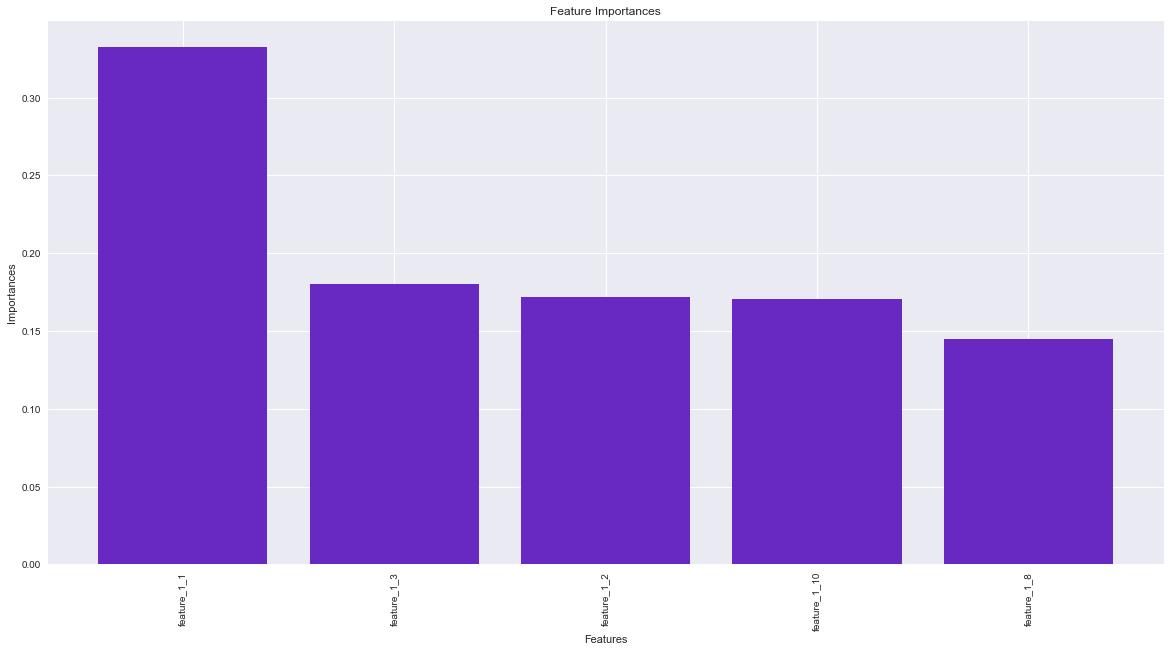

In [26]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

As we can see, most of the predictive accuracy is drawn from the roles played by the actors. This suggests that the text fields contained in this relational database have a higher impact on predictive accuracy than for most other data sets.

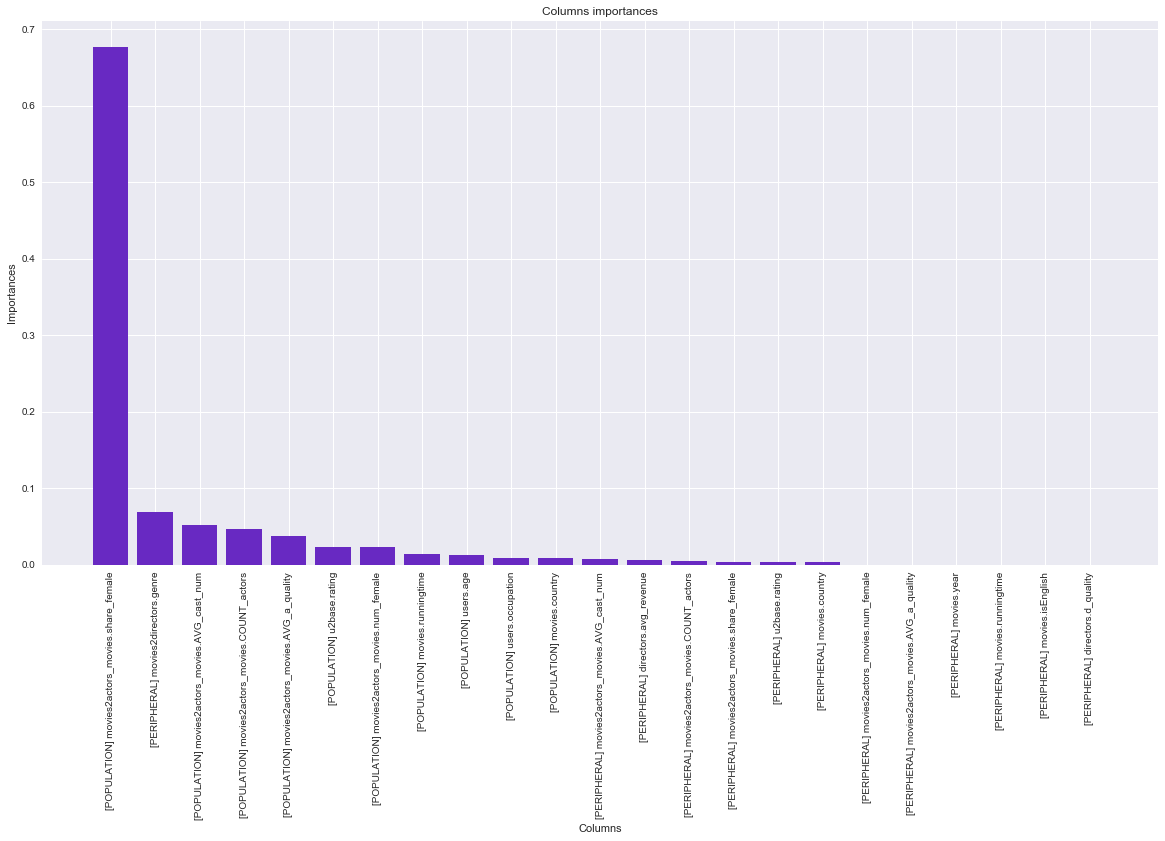

In [27]:
names, importances = pipe.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Columns importances')
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

most_important = names[0]

__Transpiling the learned features__

We can also transpile the learned features to SQLite3 code. We want to show the two most important features. That is why we call the `.features.importances().` method again. The names that are returned are already sorted by importance.

In [28]:
names, _ = pipe.features.importances()

pipe.features.to_sql()

```sql
DROP TABLE IF EXISTS "FEATURE_1_1_1";

CREATE TABLE "FEATURE_1_1_1" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.382476 ) AND ( t2."genre" IN ( 'Adventure', 'Documentary', 'Horror' ) ) AND ( t1."rating" > 3.000000 ) THEN 4.439208215665474
        WHEN ( t5."share_female" > 0.382476 ) AND ( t2."genre" IN ( 'Adventure', 'Documentary', 'Horror' ) ) AND ( t1."rating" <= 3.000000 OR t1."rating" IS NULL ) THEN -5.269292315196469
        WHEN ( t5."share_female" > 0.382476 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Documentary', 'Horror' ) ) AND ( t1."rating" > 4.000000 ) THEN 13.30354246847786
        WHEN ( t5."share_female" > 0.382476 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Documentary', 'Horror' ) ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) THEN 8.274130535901007
        WHEN ( t5."share_female" <= 0.382476 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Adventure' ) ) AND ( t5."COUNT_actors" > 40.000000 ) THEN -1.857713357855236
        WHEN ( t5."share_female" <= 0.382476 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Adventure' ) ) AND ( t5."COUNT_actors" <= 40.000000 OR t5."COUNT_actors" IS NULL ) THEN 2.645775424268971
        WHEN ( t5."share_female" <= 0.382476 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) AND ( t5."share_female" > 0.045175 ) THEN -0.9497360770001571
        WHEN ( t5."share_female" <= 0.382476 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) AND ( t5."share_female" <= 0.045175 OR t5."share_female" IS NULL ) THEN -10.20547909859999
        ELSE NULL
    END
) AS "feature_1_1_1",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_2";

CREATE TABLE "FEATURE_1_1_2" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.301501 ) AND ( t2."genre" IN ( 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" > 2.771866 ) THEN -16.50419696299251
        WHEN ( t5."share_female" > 0.301501 ) AND ( t2."genre" IN ( 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" <= 2.771866 OR t5."AVG_cast_num" IS NULL ) THEN 3.815867737432649
        WHEN ( t5."share_female" > 0.301501 ) AND ( t2."genre" NOT IN ( 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" > 1.274344 ) THEN 7.8400515284803
        WHEN ( t5."share_female" > 0.301501 ) AND ( t2."genre" NOT IN ( 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" <= 1.274344 OR t5."AVG_cast_num" IS NULL ) THEN 32.26766122003202
        WHEN ( t5."share_female" <= 0.301501 OR t5."share_female" IS NULL ) AND ( t5."num_female" > 37.000000 ) AND ( t3."runningtime" > 2.000000 ) THEN -16.9364091309437
        WHEN ( t5."share_female" <= 0.301501 OR t5."share_female" IS NULL ) AND ( t5."num_female" > 37.000000 ) AND ( t3."runningtime" <= 2.000000 OR t3."runningtime" IS NULL ) THEN -60.30912578236073
        WHEN ( t5."share_female" <= 0.301501 OR t5."share_female" IS NULL ) AND ( t5."num_female" <= 37.000000 OR t5."num_female" IS NULL ) AND ( t2."genre" IN ( 'Horror', 'Other' ) ) THEN -7.99658217098335
        WHEN ( t5."share_female" <= 0.301501 OR t5."share_female" IS NULL ) AND ( t5."num_female" <= 37.000000 OR t5."num_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Horror', 'Other' ) ) THEN -1.488176065405836
        ELSE NULL
    END
) AS "feature_1_1_2",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_3";

CREATE TABLE "FEATURE_1_1_3" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.381868 ) AND ( t2."genre" IN ( 'Adventure', 'Animation', 'Crime', 'Documentary', 'Horror' ) ) AND ( t5."share_female" > 0.385803 ) THEN 0.6354602005267965
        WHEN ( t5."share_female" > 0.381868 ) AND ( t2."genre" IN ( 'Adventure', 'Animation', 'Crime', 'Documentary', 'Horror' ) ) AND ( t5."share_female" <= 0.385803 OR t5."share_female" IS NULL ) THEN 33.70057374890223
        WHEN ( t5."share_female" > 0.381868 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Animation', 'Crime', 'Documentary', 'Horror' ) ) AND ( t1."rating" > 4.000000 ) THEN 12.12443966760431
        WHEN ( t5."share_female" > 0.381868 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Animation', 'Crime', 'Documentary', 'Horror' ) ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) THEN 6.550796104845727
        WHEN ( t5."share_female" <= 0.381868 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Adventure' ) ) AND ( t5."COUNT_actors" > 59.000000 ) THEN -11.67865669949482
        WHEN ( t5."share_female" <= 0.381868 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Adventure' ) ) AND ( t5."COUNT_actors" <= 59.000000 OR t5."COUNT_actors" IS NULL ) THEN 2.043930893011091
        WHEN ( t5."share_female" <= 0.381868 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) AND ( t3."runningtime" > 1.000000 ) THEN -0.4966624164463792
        WHEN ( t5."share_female" <= 0.381868 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) AND ( t3."runningtime" <= 1.000000 OR t3."runningtime" IS NULL ) THEN -2.780528828810678
        ELSE NULL
    END
) AS "feature_1_1_3",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_4";

CREATE TABLE "FEATURE_1_1_4" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.368421 ) AND ( t2."genre" IN ( 'Adventure', 'Horror' ) ) AND ( t4."avg_revenue" > 1.000000 ) THEN -0.5864641826724319
        WHEN ( t5."share_female" > 0.368421 ) AND ( t2."genre" IN ( 'Adventure', 'Horror' ) ) AND ( t4."avg_revenue" <= 1.000000 OR t4."avg_revenue" IS NULL ) THEN 27.96327508257333
        WHEN ( t5."share_female" > 0.368421 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Horror' ) ) AND ( t1."rating" > 4.000000 ) THEN 8.958333827906717
        WHEN ( t5."share_female" > 0.368421 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Horror' ) ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) THEN 4.724085694671463
        WHEN ( t5."share_female" <= 0.368421 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" > 0.045334 ) THEN -1.192201724782698
        WHEN ( t5."share_female" <= 0.368421 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" <= 0.045334 OR t5."share_female" IS NULL ) THEN -11.93410059993483
        WHEN ( t5."share_female" <= 0.368421 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."COUNT_actors" > 53.000000 ) THEN -12.04898125190166
        WHEN ( t5."share_female" <= 0.368421 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."COUNT_actors" <= 53.000000 OR t5."COUNT_actors" IS NULL ) THEN 1.895000310854008
        ELSE NULL
    END
) AS "feature_1_1_4",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_5";

CREATE TABLE "FEATURE_1_1_5" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.340751 ) AND ( t5."AVG_cast_num" > 2.771217 ) AND ( t5."AVG_a_quality" > 3.061156 ) THEN -20.47408732234809
        WHEN ( t5."share_female" > 0.340751 ) AND ( t5."AVG_cast_num" > 2.771217 ) AND ( t5."AVG_a_quality" <= 3.061156 OR t5."AVG_a_quality" IS NULL ) THEN 31.46156360206684
        WHEN ( t5."share_female" > 0.340751 ) AND ( t5."AVG_cast_num" <= 2.771217 OR t5."AVG_cast_num" IS NULL ) AND ( t5."AVG_a_quality" > 3.013889 ) THEN 10.23008200855889
        WHEN ( t5."share_female" > 0.340751 ) AND ( t5."AVG_cast_num" <= 2.771217 OR t5."AVG_cast_num" IS NULL ) AND ( t5."AVG_a_quality" <= 3.013889 OR t5."AVG_a_quality" IS NULL ) THEN 2.111639194174437
        WHEN ( t5."share_female" <= 0.340751 OR t5."share_female" IS NULL ) AND ( t5."AVG_cast_num" > 2.618530 ) AND ( t2."genre" IN ( 'Adventure', 'Animation', 'Comedy', 'Other' ) ) THEN -8.962759670433982
        WHEN ( t5."share_female" <= 0.340751 OR t5."share_female" IS NULL ) AND ( t5."AVG_cast_num" > 2.618530 ) AND ( t2."genre" NOT IN ( 'Adventure', 'Animation', 'Comedy', 'Other' ) ) THEN 1.495067929892586
        WHEN ( t5."share_female" <= 0.340751 OR t5."share_female" IS NULL ) AND ( t5."AVG_cast_num" <= 2.618530 OR t5."AVG_cast_num" IS NULL ) AND ( t5."num_female" > 18.000000 ) THEN 11.32868441289944
        WHEN ( t5."share_female" <= 0.340751 OR t5."share_female" IS NULL ) AND ( t5."AVG_cast_num" <= 2.618530 OR t5."AVG_cast_num" IS NULL ) AND ( t5."num_female" <= 18.000000 OR t5."num_female" IS NULL ) THEN 2.901307220236893
        ELSE NULL
    END
) AS "feature_1_1_5",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_6";

CREATE TABLE "FEATURE_1_1_6" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.380109 ) AND ( t5."AVG_cast_num" > 2.325457 ) AND ( t5."share_female" > 0.665532 ) THEN 69.21328508736823
        WHEN ( t5."share_female" > 0.380109 ) AND ( t5."AVG_cast_num" > 2.325457 ) AND ( t5."share_female" <= 0.665532 OR t5."share_female" IS NULL ) THEN 7.740623998221927
        WHEN ( t5."share_female" > 0.380109 ) AND ( t5."AVG_cast_num" <= 2.325457 OR t5."AVG_cast_num" IS NULL ) AND ( t5."COUNT_actors" > 34.000000 ) THEN -4.386012271327378
        WHEN ( t5."share_female" > 0.380109 ) AND ( t5."AVG_cast_num" <= 2.325457 OR t5."AVG_cast_num" IS NULL ) AND ( t5."COUNT_actors" <= 34.000000 OR t5."COUNT_actors" IS NULL ) THEN 4.513140641161097
        WHEN ( t5."share_female" <= 0.380109 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 3.958009 ) AND ( t3."country" IN ( 'other', 'UK' ) ) THEN -3.87434286870094
        WHEN ( t5."share_female" <= 0.380109 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 3.958009 ) AND ( t3."country" NOT IN ( 'other', 'UK' ) ) THEN 0.6444654482705473
        WHEN ( t5."share_female" <= 0.380109 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 3.958009 OR t5."AVG_a_quality" IS NULL ) AND ( t5."num_female" > 36.000000 ) THEN -9.418261535934395
        WHEN ( t5."share_female" <= 0.380109 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 3.958009 OR t5."AVG_a_quality" IS NULL ) AND ( t5."num_female" <= 36.000000 OR t5."num_female" IS NULL ) THEN -1.59437808696235
        ELSE NULL
    END
) AS "feature_1_1_6",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_7";

CREATE TABLE "FEATURE_1_1_7" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.414266 ) AND ( t5."AVG_cast_num" > 2.332696 ) AND ( t5."num_female" > 17.000000 ) THEN 8.134136408788001
        WHEN ( t5."share_female" > 0.414266 ) AND ( t5."AVG_cast_num" > 2.332696 ) AND ( t5."num_female" <= 17.000000 OR t5."num_female" IS NULL ) THEN 39.45804140432002
        WHEN ( t5."share_female" > 0.414266 ) AND ( t5."AVG_cast_num" <= 2.332696 OR t5."AVG_cast_num" IS NULL ) AND ( t5."AVG_a_quality" > 3.828125 ) THEN 8.387442618410814
        WHEN ( t5."share_female" > 0.414266 ) AND ( t5."AVG_cast_num" <= 2.332696 OR t5."AVG_cast_num" IS NULL ) AND ( t5."AVG_a_quality" <= 3.828125 OR t5."AVG_a_quality" IS NULL ) THEN -0.1795073850892733
        WHEN ( t5."share_female" <= 0.414266 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.179290 ) AND ( t2."genre" IN ( 'Action', 'Comedy', 'Drama', 'Horror' ) ) THEN 1.231178287924454
        WHEN ( t5."share_female" <= 0.414266 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.179290 ) AND ( t2."genre" NOT IN ( 'Action', 'Comedy', 'Drama', 'Horror' ) ) THEN 3.676569927461943
        WHEN ( t5."share_female" <= 0.414266 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.179290 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.127239 ) THEN -4.170527749879795
        WHEN ( t5."share_female" <= 0.414266 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.179290 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.127239 OR t5."share_female" IS NULL ) THEN 0.1269839317447451
        ELSE NULL
    END
) AS "feature_1_1_7",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_8";

CREATE TABLE "FEATURE_1_1_8" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.382114 ) AND ( t5."share_female" > 0.492898 ) AND ( t5."num_female" > 24.000000 ) THEN 13.10519189664096
        WHEN ( t5."share_female" > 0.382114 ) AND ( t5."share_female" > 0.492898 ) AND ( t5."num_female" <= 24.000000 OR t5."num_female" IS NULL ) THEN 3.153297057726014
        WHEN ( t5."share_female" > 0.382114 ) AND ( t5."share_female" <= 0.492898 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.483571 ) THEN -17.77160031376027
        WHEN ( t5."share_female" > 0.382114 ) AND ( t5."share_female" <= 0.492898 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.483571 OR t5."share_female" IS NULL ) THEN 0.5713811187419812
        WHEN ( t5."share_female" <= 0.382114 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" > 0.049636 ) THEN -4.19667011766865
        WHEN ( t5."share_female" <= 0.382114 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" <= 0.049636 OR t5."share_female" IS NULL ) THEN -14.7233761567303
        WHEN ( t5."share_female" <= 0.382114 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" > 2.072368 ) THEN -4.873530949204038
        WHEN ( t5."share_female" <= 0.382114 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Other' ) ) AND ( t5."AVG_cast_num" <= 2.072368 OR t5."AVG_cast_num" IS NULL ) THEN 2.086716352701849
        ELSE NULL
    END
) AS "feature_1_1_8",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_9";

CREATE TABLE "FEATURE_1_1_9" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.297260 ) AND ( t5."AVG_a_quality" > 3.034021 ) AND ( t5."share_female" > 0.599745 ) THEN -5.791550206557184
        WHEN ( t5."share_female" > 0.297260 ) AND ( t5."AVG_a_quality" > 3.034021 ) AND ( t5."share_female" <= 0.599745 OR t5."share_female" IS NULL ) THEN 3.650118025757397
        WHEN ( t5."share_female" > 0.297260 ) AND ( t5."AVG_a_quality" <= 3.034021 OR t5."AVG_a_quality" IS NULL ) AND ( t3."runningtime" > 2.000000 ) THEN 17.68028359326993
        WHEN ( t5."share_female" > 0.297260 ) AND ( t5."AVG_a_quality" <= 3.034021 OR t5."AVG_a_quality" IS NULL ) AND ( t3."runningtime" <= 2.000000 OR t3."runningtime" IS NULL ) THEN -4.311860566695382
        WHEN ( t5."share_female" <= 0.297260 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 136.000000 ) AND ( t1."rating" > 3.000000 ) THEN -22.69083569017657
        WHEN ( t5."share_female" <= 0.297260 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 136.000000 ) AND ( t1."rating" <= 3.000000 OR t1."rating" IS NULL ) THEN -5.046022278946797
        WHEN ( t5."share_female" <= 0.297260 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 136.000000 OR t5."COUNT_actors" IS NULL ) AND ( t5."AVG_cast_num" > 2.808252 ) THEN 112.1672726894042
        WHEN ( t5."share_female" <= 0.297260 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 136.000000 OR t5."COUNT_actors" IS NULL ) AND ( t5."AVG_cast_num" <= 2.808252 OR t5."AVG_cast_num" IS NULL ) THEN -1.209298704013169
        ELSE NULL
    END
) AS "feature_1_1_9",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_10";

CREATE TABLE "FEATURE_1_1_10" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.302198 ) AND ( t2."genre" IN ( 'Drama' ) ) AND ( t5."COUNT_actors" > 81.000000 ) THEN -28.06176352550474
        WHEN ( t5."share_female" > 0.302198 ) AND ( t2."genre" IN ( 'Drama' ) ) AND ( t5."COUNT_actors" <= 81.000000 OR t5."COUNT_actors" IS NULL ) THEN -2.007557195237608
        WHEN ( t5."share_female" > 0.302198 ) AND ( t2."genre" NOT IN ( 'Drama' ) ) AND ( t5."AVG_cast_num" > 2.764702 ) THEN -23.76853312507381
        WHEN ( t5."share_female" > 0.302198 ) AND ( t2."genre" NOT IN ( 'Drama' ) ) AND ( t5."AVG_cast_num" <= 2.764702 OR t5."AVG_cast_num" IS NULL ) THEN -7.453420525872659
        WHEN ( t5."share_female" <= 0.302198 OR t5."share_female" IS NULL ) AND ( t4."avg_revenue" > 3.000000 ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN -10.59807398706811
        WHEN ( t5."share_female" <= 0.302198 OR t5."share_female" IS NULL ) AND ( t4."avg_revenue" > 3.000000 ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN -6.123043764730713
        WHEN ( t5."share_female" <= 0.302198 OR t5."share_female" IS NULL ) AND ( t4."avg_revenue" <= 3.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."AVG_cast_num" > 2.319031 ) THEN -18.01050519829709
        WHEN ( t5."share_female" <= 0.302198 OR t5."share_female" IS NULL ) AND ( t4."avg_revenue" <= 3.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."AVG_cast_num" <= 2.319031 OR t5."AVG_cast_num" IS NULL ) THEN -11.2804096838691
        ELSE NULL
    END
) AS "feature_1_1_10",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_11";

CREATE TABLE "FEATURE_1_1_11" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.382920 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" > 2.332063 ) THEN 0.06145210103152271
        WHEN ( t5."share_female" > 0.382920 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" <= 2.332063 OR t5."AVG_cast_num" IS NULL ) THEN 0.00601240299661283
        WHEN ( t5."share_female" > 0.382920 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t5."share_female" > 0.396011 ) THEN 0.07192580435995818
        WHEN ( t5."share_female" > 0.382920 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t5."share_female" <= 0.396011 OR t5."share_female" IS NULL ) THEN 0.1951058656462275
        WHEN ( t5."share_female" <= 0.382920 OR t5."share_female" IS NULL ) AND ( t5."num_female" > 29.000000 ) AND ( t2."genre" IN ( 'Action', 'Comedy', 'Documentary', 'Other' ) ) THEN -0.09732031516054282
        WHEN ( t5."share_female" <= 0.382920 OR t5."share_female" IS NULL ) AND ( t5."num_female" > 29.000000 ) AND ( t2."genre" NOT IN ( 'Action', 'Comedy', 'Documentary', 'Other' ) ) THEN 0.0538328307201344
        WHEN ( t5."share_female" <= 0.382920 OR t5."share_female" IS NULL ) AND ( t5."num_female" <= 29.000000 OR t5."num_female" IS NULL ) AND ( t5."share_female" > 0.029271 ) THEN -0.008752558146737978
        WHEN ( t5."share_female" <= 0.382920 OR t5."share_female" IS NULL ) AND ( t5."num_female" <= 29.000000 OR t5."num_female" IS NULL ) AND ( t5."share_female" <= 0.029271 OR t5."share_female" IS NULL ) THEN -0.1001427062643074
        ELSE NULL
    END
) AS "feature_1_1_11",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_12";

CREATE TABLE "FEATURE_1_1_12" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.381085 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" > 2.328903 ) THEN 0.05832759357902421
        WHEN ( t5."share_female" > 0.381085 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" <= 2.328903 OR t5."AVG_cast_num" IS NULL ) THEN 0.003617067425763789
        WHEN ( t5."share_female" > 0.381085 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t5."AVG_cast_num" > 2.034340 ) THEN 0.1887181347791278
        WHEN ( t5."share_female" > 0.381085 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t5."AVG_cast_num" <= 2.034340 OR t5."AVG_cast_num" IS NULL ) THEN 0.06457916075592603
        WHEN ( t5."share_female" <= 0.381085 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 95.000000 ) AND ( t5."num_female" > 14.000000 ) THEN -0.06334633905376542
        WHEN ( t5."share_female" <= 0.381085 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 95.000000 ) AND ( t5."num_female" <= 14.000000 OR t5."num_female" IS NULL ) THEN -0.3072234915609658
        WHEN ( t5."share_female" <= 0.381085 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 95.000000 OR t5."COUNT_actors" IS NULL ) AND ( t5."AVG_a_quality" > 4.311688 ) THEN -0.1176895191588121
        WHEN ( t5."share_female" <= 0.381085 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 95.000000 OR t5."COUNT_actors" IS NULL ) AND ( t5."AVG_a_quality" <= 4.311688 OR t5."AVG_a_quality" IS NULL ) THEN -0.008451925200749751
        ELSE NULL
    END
) AS "feature_1_1_12",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_13";

CREATE TABLE "FEATURE_1_1_13" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.381018 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t3."year" > 2.000000 ) THEN 0.03313686213847201
        WHEN ( t5."share_female" > 0.381018 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) THEN 0.2557694188095031
        WHEN ( t5."share_female" > 0.381018 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."share_female" > 0.395667 ) THEN 0.0116771847956914
        WHEN ( t5."share_female" > 0.381018 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."share_female" <= 0.395667 OR t5."share_female" IS NULL ) THEN -0.2753002228976409
        WHEN ( t5."share_female" <= 0.381018 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 4.286834 ) AND ( t5."AVG_a_quality" > 4.429777 ) THEN 0.04079465031972577
        WHEN ( t5."share_female" <= 0.381018 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 4.286834 ) AND ( t5."AVG_a_quality" <= 4.429777 OR t5."AVG_a_quality" IS NULL ) THEN -0.2399318173511911
        WHEN ( t5."share_female" <= 0.381018 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 4.286834 OR t5."AVG_a_quality" IS NULL ) AND ( t5."AVG_cast_num" > 2.838545 ) THEN -0.2913460020879832
        WHEN ( t5."share_female" <= 0.381018 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 4.286834 OR t5."AVG_a_quality" IS NULL ) AND ( t5."AVG_cast_num" <= 2.838545 OR t5."AVG_cast_num" IS NULL ) THEN -0.009112445061638726
        ELSE NULL
    END
) AS "feature_1_1_13",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_14";

CREATE TABLE "FEATURE_1_1_14" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.382271 ) AND ( t4."avg_revenue" > 3.000000 ) AND ( t5."AVG_a_quality" > 3.788280 ) THEN 0.1181847878975137
        WHEN ( t5."share_female" > 0.382271 ) AND ( t4."avg_revenue" > 3.000000 ) AND ( t5."AVG_a_quality" <= 3.788280 OR t5."AVG_a_quality" IS NULL ) THEN 0.03393118127709603
        WHEN ( t5."share_female" > 0.382271 ) AND ( t4."avg_revenue" <= 3.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."COUNT_actors" > 130.000000 ) THEN -0.4824460454399158
        WHEN ( t5."share_female" > 0.382271 ) AND ( t4."avg_revenue" <= 3.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."COUNT_actors" <= 130.000000 OR t5."COUNT_actors" IS NULL ) THEN 0.02006535910554342
        WHEN ( t5."share_female" <= 0.382271 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 4.086614 ) AND ( t5."AVG_a_quality" > 4.144781 ) THEN -0.03312801800937196
        WHEN ( t5."share_female" <= 0.382271 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" > 4.086614 ) AND ( t5."AVG_a_quality" <= 4.144781 OR t5."AVG_a_quality" IS NULL ) THEN -0.4071414963722156
        WHEN ( t5."share_female" <= 0.382271 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 4.086614 OR t5."AVG_a_quality" IS NULL ) AND ( t2."genre" IN ( 'Adventure' ) ) THEN 0.007866457577259536
        WHEN ( t5."share_female" <= 0.382271 OR t5."share_female" IS NULL ) AND ( t5."AVG_a_quality" <= 4.086614 OR t5."AVG_a_quality" IS NULL ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) THEN -0.01268484121779736
        ELSE NULL
    END
) AS "feature_1_1_14",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_15";

CREATE TABLE "FEATURE_1_1_15" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.355586 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t2."genre" IN ( 'Action', 'Adventure', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) THEN 0.01525818524944128
        WHEN ( t5."share_female" > 0.355586 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t2."genre" NOT IN ( 'Action', 'Adventure', 'Comedy', 'Crime', 'Documentary', 'Horror', 'Other' ) ) THEN 0.05472174272163986
        WHEN ( t5."share_female" > 0.355586 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t4."avg_revenue" > 0.000000 ) THEN -0.01506108776410837
        WHEN ( t5."share_female" > 0.355586 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t4."avg_revenue" <= 0.000000 OR t4."avg_revenue" IS NULL ) THEN 0.07589465424941813
        WHEN ( t5."share_female" <= 0.355586 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.354409 ) AND ( t1."rating" > 3.000000 ) THEN -0.3189183615658661
        WHEN ( t5."share_female" <= 0.355586 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.354409 ) AND ( t1."rating" <= 3.000000 OR t1."rating" IS NULL ) THEN -0.1205352228159956
        WHEN ( t5."share_female" <= 0.355586 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.354409 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.349589 ) THEN 0.08368627376048722
        WHEN ( t5."share_female" <= 0.355586 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.354409 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.349589 OR t5."share_female" IS NULL ) THEN -0.01178059016824378
        ELSE NULL
    END
) AS "feature_1_1_15",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_16";

CREATE TABLE "FEATURE_1_1_16" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.381471 ) AND ( t5."COUNT_actors" > 83.000000 ) AND ( t3."runningtime" > 2.000000 ) THEN -0.0250258392328856
        WHEN ( t5."share_female" > 0.381471 ) AND ( t5."COUNT_actors" > 83.000000 ) AND ( t3."runningtime" <= 2.000000 OR t3."runningtime" IS NULL ) THEN -0.2433274222065845
        WHEN ( t5."share_female" > 0.381471 ) AND ( t5."COUNT_actors" <= 83.000000 OR t5."COUNT_actors" IS NULL ) AND ( t4."avg_revenue" > 2.000000 ) THEN 0.04519987316787903
        WHEN ( t5."share_female" > 0.381471 ) AND ( t5."COUNT_actors" <= 83.000000 OR t5."COUNT_actors" IS NULL ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) THEN 0.006122577283825829
        WHEN ( t5."share_female" <= 0.381471 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Other' ) ) AND ( t5."COUNT_actors" > 176.000000 ) THEN -0.2396103355996192
        WHEN ( t5."share_female" <= 0.381471 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Other' ) ) AND ( t5."COUNT_actors" <= 176.000000 OR t5."COUNT_actors" IS NULL ) THEN -0.01298439182961336
        WHEN ( t5."share_female" <= 0.381471 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" > 0.378762 ) THEN 0.6649644497810465
        WHEN ( t5."share_female" <= 0.381471 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Comedy', 'Crime', 'Drama', 'Horror', 'Other' ) ) AND ( t5."share_female" <= 0.378762 OR t5."share_female" IS NULL ) THEN 0.00143167112708014
        ELSE NULL
    END
) AS "feature_1_1_16",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_17";

CREATE TABLE "FEATURE_1_1_17" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.383333 ) AND ( t5."share_female" > 0.386919 ) AND ( t3."year" > 2.000000 ) THEN 0.02177885892119465
        WHEN ( t5."share_female" > 0.383333 ) AND ( t5."share_female" > 0.386919 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) THEN 0.07686810786778889
        WHEN ( t5."share_female" > 0.383333 ) AND ( t5."share_female" <= 0.386919 OR t5."share_female" IS NULL ) AND ( t2."genre" IN ( 'Comedy', 'Documentary', 'Drama', 'Horror' ) ) THEN 0.1239307122960044
        WHEN ( t5."share_female" > 0.383333 ) AND ( t5."share_female" <= 0.386919 OR t5."share_female" IS NULL ) AND ( t2."genre" NOT IN ( 'Comedy', 'Documentary', 'Drama', 'Horror' ) ) THEN 0.3321641438165037
        WHEN ( t5."share_female" <= 0.383333 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.030251 ) AND ( t5."COUNT_actors" > 220.000000 ) THEN -0.2210862074145951
        WHEN ( t5."share_female" <= 0.383333 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.030251 ) AND ( t5."COUNT_actors" <= 220.000000 OR t5."COUNT_actors" IS NULL ) THEN -0.00932452560030704
        WHEN ( t5."share_female" <= 0.383333 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.030251 OR t5."share_female" IS NULL ) AND ( t3."country" IN ( 'France' ) ) THEN 1.574168402044292
        WHEN ( t5."share_female" <= 0.383333 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.030251 OR t5."share_female" IS NULL ) AND ( t3."country" NOT IN ( 'France' ) ) THEN -0.09842692505617083
        ELSE NULL
    END
) AS "feature_1_1_17",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_18";

CREATE TABLE "FEATURE_1_1_18" AS
SELECT AVG( 
    CASE
        WHEN ( t5."share_female" > 0.382393 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t5."AVG_a_quality" > 3.902209 ) THEN 0.1083932903796876
        WHEN ( t5."share_female" > 0.382393 ) AND ( t4."avg_revenue" > 2.000000 ) AND ( t5."AVG_a_quality" <= 3.902209 OR t5."AVG_a_quality" IS NULL ) THEN 0.02323104800069518
        WHEN ( t5."share_female" > 0.382393 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."share_female" > 0.404027 ) THEN 0.0163941099810157
        WHEN ( t5."share_female" > 0.382393 ) AND ( t4."avg_revenue" <= 2.000000 OR t4."avg_revenue" IS NULL ) AND ( t5."share_female" <= 0.404027 OR t5."share_female" IS NULL ) THEN -0.1356106870785422
        WHEN ( t5."share_female" <= 0.382393 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.079582 ) AND ( t5."num_female" > 43.000000 ) THEN -0.2033862858659178
        WHEN ( t5."share_female" <= 0.382393 OR t5."share_female" IS NULL ) AND ( t5."share_female" > 0.079582 ) AND ( t5."num_female" <= 43.000000 OR t5."num_female" IS NULL ) THEN -0.00668626862338815
        WHEN ( t5."share_female" <= 0.382393 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.079582 OR t5."share_female" IS NULL ) AND ( t1."rating" > 3.000000 ) THEN -0.05807182069999459
        WHEN ( t5."share_female" <= 0.382393 OR t5."share_female" IS NULL ) AND ( t5."share_female" <= 0.079582 OR t5."share_female" IS NULL ) AND ( t1."rating" <= 3.000000 OR t1."rating" IS NULL ) THEN -0.01894113773931498
        ELSE NULL
    END
) AS "feature_1_1_18",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_19";

CREATE TABLE "FEATURE_1_1_19" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.357823 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" > 2.336694 ) THEN 0.04022290662837702
        WHEN ( t5."share_female" > 0.357823 ) AND ( t3."year" > 2.000000 ) AND ( t5."AVG_cast_num" <= 2.336694 OR t5."AVG_cast_num" IS NULL ) THEN -0.001658661670963714
        WHEN ( t5."share_female" > 0.357823 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t1."rating" > 4.000000 ) THEN 0.08558016688296999
        WHEN ( t5."share_female" > 0.357823 ) AND ( t3."year" <= 2.000000 OR t3."year" IS NULL ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) THEN 0.0394402537332476
        WHEN ( t5."share_female" <= 0.357823 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 136.000000 ) AND ( t1."rating" > 1.000000 ) THEN -0.1400611919743407
        WHEN ( t5."share_female" <= 0.357823 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" > 136.000000 ) AND ( t1."rating" <= 1.000000 OR t1."rating" IS NULL ) THEN 0.09727846371553717
        WHEN ( t5."share_female" <= 0.357823 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 136.000000 OR t5."COUNT_actors" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN -0.01301188169927387
        WHEN ( t5."share_female" <= 0.357823 OR t5."share_female" IS NULL ) AND ( t5."COUNT_actors" <= 136.000000 OR t5."COUNT_actors" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN 0.005838648178728916
        ELSE NULL
    END
) AS "feature_1_1_19",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1_20";

CREATE TABLE "FEATURE_1_1_20" AS
SELECT SUM( 
    CASE
        WHEN ( t5."share_female" > 0.357241 ) AND ( t1."rating" > 4.000000 ) AND ( t5."share_female" > 0.446226 ) THEN -0.01285209064843055
        WHEN ( t5."share_female" > 0.357241 ) AND ( t1."rating" > 4.000000 ) AND ( t5."share_female" <= 0.446226 OR t5."share_female" IS NULL ) THEN 0.07264997485148414
        WHEN ( t5."share_female" > 0.357241 ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) AND ( t5."AVG_cast_num" > 2.766866 ) THEN -0.2025481342171267
        WHEN ( t5."share_female" > 0.357241 ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) AND ( t5."AVG_cast_num" <= 2.766866 OR t5."AVG_cast_num" IS NULL ) THEN 0.01959289144372038
        WHEN ( t5."share_female" <= 0.357241 OR t5."share_female" IS NULL ) AND ( t1."rating" > 4.000000 ) AND ( t2."genre" IN ( 'Adventure' ) ) THEN 0.02226831508827206
        WHEN ( t5."share_female" <= 0.357241 OR t5."share_female" IS NULL ) AND ( t1."rating" > 4.000000 ) AND ( t2."genre" NOT IN ( 'Adventure' ) ) THEN -0.02175196935098901
        WHEN ( t5."share_female" <= 0.357241 OR t5."share_female" IS NULL ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) AND ( t2."genre" IN ( 'Action', 'Adventure', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN -0.010338853912309
        WHEN ( t5."share_female" <= 0.357241 OR t5."share_female" IS NULL ) AND ( t1."rating" <= 4.000000 OR t1."rating" IS NULL ) AND ( t2."genre" NOT IN ( 'Action', 'Adventure', 'Comedy', 'Documentary', 'Drama', 'Horror', 'Other' ) ) THEN 0.005369698571236299
        ELSE NULL
    END
) AS "feature_1_1_20",
     t1.rowid AS "rownum"
FROM "u2base" t1
LEFT JOIN "movies2directors" t2
ON t3."movieid" = t2."movieid"
LEFT JOIN "movies" t3
ON t1."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "directors" t4
ON t2."directorid" = t4."directorid"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_1";

CREATE TABLE "FEATURE_1_1" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 2.460768 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 33.589247 ) AND ( t1."age" > 48.000000 ) THEN 10.77017496303951
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 2.460768 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 33.589247 ) AND ( t1."age" <= 48.000000 OR t1."age" IS NULL ) THEN 49.73482768097328
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 2.460768 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 33.589247 ) AND ( COALESCE( f_1_1_7."feature_1_1_7", 0.0 ) > 8.068510 ) THEN 12.73705780867409
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 2.460768 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 33.589247 ) AND ( COALESCE( f_1_1_7."feature_1_1_7", 0.0 ) <= 8.068510 ) THEN 4.950423818813827
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 2.460768 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > -1.775805 ) AND ( COALESCE( f_1_1_7."feature_1_1_7", 0.0 ) > -0.057397 ) THEN -0.56572420209462
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 2.460768 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > -1.775805 ) AND ( COALESCE( f_1_1_7."feature_1_1_7", 0.0 ) <= -0.057397 ) THEN -6.831033046543908
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 2.460768 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= -1.775805 ) AND ( t5."AVG_cast_num" > 2.623696 ) THEN -20.63186978927445
        WHEN ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 2.460768 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= -1.775805 ) AND ( t5."AVG_cast_num" <= 2.623696 OR t5."AVG_cast_num" IS NULL ) THEN -8.046036380598858
        ELSE NULL
    END
) AS "feature_1_1",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_4" f_1_1_4
ON t2.rowid = f_1_1_4."rownum"
LEFT JOIN "FEATURE_1_1_7" f_1_1_7
ON t2.rowid = f_1_1_7."rownum"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_2";

CREATE TABLE "FEATURE_1_2" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.256238 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 2.807411 ) AND ( COALESCE( f_1_1_20."feature_1_1_20", 0.0 ) > 0.143893 ) THEN 40.32665825411078
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.256238 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 2.807411 ) AND ( COALESCE( f_1_1_20."feature_1_1_20", 0.0 ) <= 0.143893 ) THEN 8.570924772028484
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.256238 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 2.807411 ) AND ( t5."share_female" > 0.694034 ) THEN 41.32073233577999
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.256238 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 2.807411 ) AND ( t5."share_female" <= 0.694034 OR t5."share_female" IS NULL ) THEN -4.482523885067656
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.256238 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > -2.366317 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) > -11.310609 ) THEN -0.6848160343918213
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.256238 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > -2.366317 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) <= -11.310609 ) THEN -6.572704523106617
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.256238 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= -2.366317 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) > -2.675158 ) THEN -8.016533200657575
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.256238 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= -2.366317 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) <= -2.675158 ) THEN -24.72648084059444
        ELSE NULL
    END
) AS "feature_1_2",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_4" f_1_1_4
ON t2.rowid = f_1_1_4."rownum"
LEFT JOIN "FEATURE_1_1_5" f_1_1_5
ON t2.rowid = f_1_1_5."rownum"
LEFT JOIN "FEATURE_1_1_6" f_1_1_6
ON t2.rowid = f_1_1_6."rownum"
LEFT JOIN "FEATURE_1_1_9" f_1_1_9
ON t2.rowid = f_1_1_9."rownum"
LEFT JOIN "FEATURE_1_1_10" f_1_1_10
ON t2.rowid = f_1_1_10."rownum"
LEFT JOIN "FEATURE_1_1_20" f_1_1_20
ON t2.rowid = f_1_1_20."rownum"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_3";

CREATE TABLE "FEATURE_1_3" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 11.858115 ) AND ( COALESCE( f_1_1_14."feature_1_1_14", 0.0 ) > 0.032380 ) THEN 17.57890709494116
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 11.858115 ) AND ( COALESCE( f_1_1_14."feature_1_1_14", 0.0 ) <= 0.032380 ) THEN 8.318302909167359
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 11.858115 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) > 12.997981 ) THEN 16.05682904162985
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 11.858115 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) <= 12.997981 ) THEN 5.064902892228557
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > -0.044492 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) > -7.486276 ) THEN 0.5763929618740391
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > -0.044492 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) <= -7.486276 ) THEN -2.113838497906592
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= -0.044492 ) AND ( t2."rating" > 3.000000 ) THEN -20.74700241594504
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= -0.044492 ) AND ( t2."rating" <= 3.000000 OR t2."rating" IS NULL ) THEN -7.432016882372003
        ELSE NULL
    END
) AS "feature_1_3",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_5" f_1_1_5
ON t2.rowid = f_1_1_5."rownum"
LEFT JOIN "FEATURE_1_1_6" f_1_1_6
ON t2.rowid = f_1_1_6."rownum"
LEFT JOIN "FEATURE_1_1_8" f_1_1_8
ON t2.rowid = f_1_1_8."rownum"
LEFT JOIN "FEATURE_1_1_10" f_1_1_10
ON t2.rowid = f_1_1_10."rownum"
LEFT JOIN "FEATURE_1_1_14" f_1_1_14
ON t2.rowid = f_1_1_14."rownum"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_8";

CREATE TABLE "FEATURE_1_8" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 10.218597 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) > 2.015078 ) AND ( t1."age" > 55.000000 ) THEN 6.6903538897781
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 10.218597 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) > 2.015078 ) AND ( t1."age" <= 55.000000 OR t1."age" IS NULL ) THEN 13.45354160196738
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 10.218597 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) <= 2.015078 ) AND ( COALESCE( f_1_1_20."feature_1_1_20", 0.0 ) > 0.072532 ) THEN 11.69787860835723
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > 10.218597 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) <= 2.015078 ) AND ( COALESCE( f_1_1_20."feature_1_1_20", 0.0 ) <= 0.072532 ) THEN 4.859800830312462
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 10.218597 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > -0.537252 ) AND ( t1."occupation" IN ( '2', '3', '4' ) ) THEN 2.519315851005496
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 10.218597 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > -0.537252 ) AND ( t1."occupation" NOT IN ( '2', '3', '4' ) ) THEN 3.187689017382151
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 10.218597 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= -0.537252 ) AND ( t5."COUNT_actors" > 74.000000 ) THEN -11.96551466019815
        WHEN ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= 10.218597 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= -0.537252 ) AND ( t5."COUNT_actors" <= 74.000000 OR t5."COUNT_actors" IS NULL ) THEN -0.9940198270315207
        ELSE NULL
    END
) AS "feature_1_8",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_5" f_1_1_5
ON t2.rowid = f_1_1_5."rownum"
LEFT JOIN "FEATURE_1_1_8" f_1_1_8
ON t2.rowid = f_1_1_8."rownum"
LEFT JOIN "FEATURE_1_1_20" f_1_1_20
ON t2.rowid = f_1_1_20."rownum"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURE_1_10";

CREATE TABLE "FEATURE_1_10" AS
SELECT SUM( 
    CASE
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.267335 ) AND ( COALESCE( f_1_1_16."feature_1_1_16", 0.0 ) > 0.044304 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 33.600414 ) THEN 0.2401766427419586
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.267335 ) AND ( COALESCE( f_1_1_16."feature_1_1_16", 0.0 ) > 0.044304 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 33.600414 ) THEN 0.03356687566313831
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.267335 ) AND ( COALESCE( f_1_1_16."feature_1_1_16", 0.0 ) <= 0.044304 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) > 8.965600 ) THEN 0.1191066245422096
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.267335 ) AND ( COALESCE( f_1_1_16."feature_1_1_16", 0.0 ) <= 0.044304 ) AND ( COALESCE( f_1_1_4."feature_1_1_4", 0.0 ) <= 8.965600 ) THEN -0.006033971134517391
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.267335 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) > -5.222137 ) AND ( COALESCE( f_1_1_15."feature_1_1_15", 0.0 ) > 0.053752 ) THEN 0.0571761952157499
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.267335 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) > -5.222137 ) AND ( COALESCE( f_1_1_15."feature_1_1_15", 0.0 ) <= 0.053752 ) THEN -0.01085987550181183
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.267335 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) <= -5.222137 ) AND ( t3."country" IN ( 'USA' ) ) THEN -0.169516673758467
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.267335 ) AND ( COALESCE( f_1_1_9."feature_1_1_9", 0.0 ) <= -5.222137 ) AND ( t3."country" NOT IN ( 'USA' ) ) THEN 0.004060853595658041
        ELSE NULL
    END
) AS "feature_1_10",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_4" f_1_1_4
ON t2.rowid = f_1_1_4."rownum"
LEFT JOIN "FEATURE_1_1_6" f_1_1_6
ON t2.rowid = f_1_1_6."rownum"
LEFT JOIN "FEATURE_1_1_9" f_1_1_9
ON t2.rowid = f_1_1_9."rownum"
LEFT JOIN "FEATURE_1_1_15" f_1_1_15
ON t2.rowid = f_1_1_15."rownum"
LEFT JOIN "FEATURE_1_1_16" f_1_1_16
ON t2.rowid = f_1_1_16."rownum"
GROUP BY t1.rowid;


DROP TABLE IF EXISTS "FEATURES";

CREATE TABLE "FEATURES" AS
SELECT        CAST( COALESCE( f_1_1."feature_1_1", 0.0 ) AS REAL ) AS "feature_1_1",
       CAST( COALESCE( f_1_2."feature_1_2", 0.0 ) AS REAL ) AS "feature_1_2",
       CAST( COALESCE( f_1_3."feature_1_3", 0.0 ) AS REAL ) AS "feature_1_3",
       CAST( COALESCE( f_1_8."feature_1_8", 0.0 ) AS REAL ) AS "feature_1_8",
       CAST( COALESCE( f_1_10."feature_1_10", 0.0 ) AS REAL ) AS "feature_1_10",
CAST( t1."target" AS REAL ) AS "target_1__target"
FROM "users" t1
LEFT JOIN "FEATURE_1_1" f_1_1
ON t1.rowid = f_1_1."rownum"
LEFT JOIN "FEATURE_1_2" f_1_2
ON t1.rowid = f_1_2."rownum"
LEFT JOIN "FEATURE_1_3" f_1_3
ON t1.rowid = f_1_3."rownum"
LEFT JOIN "FEATURE_1_8" f_1_8
ON t1.rowid = f_1_8."rownum"
LEFT JOIN "FEATURE_1_10" f_1_10
ON t1.rowid = f_1_10."rownum"
ORDER BY t1.rowid;

DROP TABLE IF EXISTS "FEATURE_1_1_1";
DROP TABLE IF EXISTS "FEATURE_1_1_2";
DROP TABLE IF EXISTS "FEATURE_1_1_3";
DROP TABLE IF EXISTS "FEATURE_1_1_4";
DROP TABLE IF EXISTS "FEATURE_1_1_5";
DROP TABLE IF EXISTS "FEATURE_1_1_6";
DROP TABLE IF EXISTS "FEATURE_1_1_7";
DROP TABLE IF EXISTS "FEATURE_1_1_8";
DROP TABLE IF EXISTS "FEATURE_1_1_9";
DROP TABLE IF EXISTS "FEATURE_1_1_10";
DROP TABLE IF EXISTS "FEATURE_1_1_11";
DROP TABLE IF EXISTS "FEATURE_1_1_12";
DROP TABLE IF EXISTS "FEATURE_1_1_13";
DROP TABLE IF EXISTS "FEATURE_1_1_14";
DROP TABLE IF EXISTS "FEATURE_1_1_15";
DROP TABLE IF EXISTS "FEATURE_1_1_16";
DROP TABLE IF EXISTS "FEATURE_1_1_17";
DROP TABLE IF EXISTS "FEATURE_1_1_18";
DROP TABLE IF EXISTS "FEATURE_1_1_19";
DROP TABLE IF EXISTS "FEATURE_1_1_20";
DROP TABLE IF EXISTS "FEATURE_1_1";
DROP TABLE IF EXISTS "FEATURE_1_2";
DROP TABLE IF EXISTS "FEATURE_1_3";
DROP TABLE IF EXISTS "FEATURE_1_8";
DROP TABLE IF EXISTS "FEATURE_1_10";

```

In [29]:
names, _ = pipe.features.importances()

pipe.features.to_sql()[names[1]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_3";

CREATE TABLE "FEATURE_1_3" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 11.858115 ) AND ( COALESCE( f_1_1_14."feature_1_1_14", 0.0 ) > 0.032380 ) THEN 17.57890709494116
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) > 11.858115 ) AND ( COALESCE( f_1_1_14."feature_1_1_14", 0.0 ) <= 0.032380 ) THEN 8.318302909167359
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 11.858115 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) > 12.997981 ) THEN 16.05682904162985
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) > 1.274414 ) AND ( COALESCE( f_1_1_3."feature_1_1_3", 0.0 ) <= 11.858115 ) AND ( COALESCE( f_1_1_8."feature_1_1_8", 0.0 ) <= 12.997981 ) THEN 5.064902892228557
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > -0.044492 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) > -7.486276 ) THEN 0.5763929618740391
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) > -0.044492 ) AND ( COALESCE( f_1_1_10."feature_1_1_10", 0.0 ) <= -7.486276 ) THEN -2.113838497906592
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= -0.044492 ) AND ( t2."rating" > 3.000000 ) THEN -20.74700241594504
        WHEN ( COALESCE( f_1_1_6."feature_1_1_6", 0.0 ) <= 1.274414 ) AND ( COALESCE( f_1_1_5."feature_1_1_5", 0.0 ) <= -0.044492 ) AND ( t2."rating" <= 3.000000 OR t2."rating" IS NULL ) THEN -7.432016882372003
        ELSE NULL
    END
) AS "feature_1_3",
     t1.rowid AS "rownum"
FROM "users" t1
LEFT JOIN "u2base" t2
ON t1."userid" = t2."userid"
LEFT JOIN "movies" t3
ON t2."movieid" = t3."movieid"
LEFT JOIN "movies2actors_movies" t5
ON t3."movieid" = t5."movieid"
LEFT JOIN "FEATURE_1_1_3" f_1_1_3
ON t2.rowid = f_1_1_3."rownum"
LEFT JOIN "FEATURE_1_1_5" f_1_1_5
ON t2.rowid = f_1_1_5."rownum"
LEFT JOIN "FEATURE_1_1_6" f_1_1_6
ON t2.rowid = f_1_1_6."rownum"
LEFT JOIN "FEATURE_1_1_8" f_1_1_8
ON t2.rowid = f_1_1_8."rownum"
LEFT JOIN "FEATURE_1_1_10" f_1_1_10
ON t2.rowid = f_1_1_10."rownum"
LEFT JOIN "FEATURE_1_1_14" f_1_1_14
ON t2.rowid = f_1_1_14."rownum"
GROUP BY t1.rowid;
```

### 2.7 Benchmarks

## 3. Conclusion

In this notebook we have demonstrated how getML can be applied to text fields. We have demonstrated the our  approach outperforms state-of-the-art relational learning algorithms on the IMdb dataset.

## Citations

Motl, Jan, and Oliver Schulte. "The CTU prague relational learning repository." arXiv preprint arXiv:1511.03086 (2015).
    
Neville, Jennifer, and David Jensen. "Relational dependency networks." Journal of Machine Learning Research 8.Mar (2007): 653-692.
    
Neville, Jennifer, and David Jensen. "Collective classification with relational dependency networks." Workshop on Multi-Relational Data Mining (MRDM-2003). 2003.
    
Neville, Jennifer, et al. "Learning relational probability trees." Proceedings of the Ninth ACM SIGKDD international conference on Knowledge discovery and data mining. 2003.
    
Perovšek, Matic, et al. "Wordification: Propositionalization by unfolding relational data into bags of words." Expert Systems with Applications 42.17-18 (2015): 6442-6456.

# Next Steps

This tutorial went through the basics of applying getML to relational data. If you want to learn more about getML, here are some additional tutorials and articles that will help you:

__Tutorials:__
* [Loan default prediction: Introduction to relational learning](loans_demo.ipynb)
* [Occupancy detection: A multivariate time series example](occupancy_demo.ipynb)  
* [Expenditure categorization: Why relational learning matters](consumer_expenditures_demo.ipynb)
* [Disease lethality prediction: Feature engineering and the curse of dimensionality](atherosclerosis_demo.ipynb)
* [Traffic volume prediction: Feature engineering on multivariate time series](interstate94_demo.ipynb)
* [Air pollution prediction: Why feature learning outperforms brute-force approaches](air_pollution_demo.ipynb) 


__User Guides__ (from our [documentation](https://docs.getml.com/latest/)):
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)


# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.